# COVID-19 Data Analyses using New York Times Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is 
[COVID-19 data from The New York Times](https://github.com/nytimes/covid-19-data).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the New York Times COVID-19 CSV files into [Pandas](https://pandas.pydata.org/) DataFrames. It
then manipulates, queries, and plots data via the DataFrames.

[**I don't want to look at code. Take me to the first graph!**](#United-States-as-a-whole)


[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date, timezone
import os
import sys
import re
import math
from pprint import pprint
from glob import glob
from collections import namedtuple
from lib.common import *
from lib.plot import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")
now = datetime.now(timezone.utc)
print(f"Last run on {now.strftime('%Y-%m-%d')} at {now.strftime('%H:%M:%S %Z')}")

Using Python 3.8.6
Using matplotlib 3.3.2
Using Pandas 1.1.4
Last run on 2021-01-04 at 16:40:44 UTC


In [2]:
NYTIMES_DIR_PATH = 'data/nytimes/covid-19-data'
SOURCE = "New York Times"
US_DATA = os.path.join(NYTIMES_DIR_PATH, 'us.csv')
US_STATE_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-states.csv')
US_COUNTY_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-counties.csv')

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

In [4]:
for p in glob(os.path.join(IMAGES_PATH, 'nyt*')):
    os.unlink(p)

## State population data

In [5]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


## Read the New York Times data

In [6]:
def read_us_data(path: str) -> pd.DataFrame:
    """
    Reads the New York Times COVID-19 US-wide CSV file
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path).rename(columns={
            'date':   COL_DATE,
            'state':  COL_REGION,
            'cases':  COL_CASES,
            'deaths': COL_DEATHS
        })
    df = df[[COL_DATE, COL_REGION, COL_CASES, COL_DEATHS]]

    df[COL_DATE] = pd.to_datetime(df[COL_DATE], format='%Y-%m-%d')
    df[COL_DEATHS].fillna(0)
    df[COL_CASES].fillna(0)

    df[COL_HOSPITALIZATIONS] = 0
    df[COL_RECOVERIES] = 0
    df[COL_TESTS] = 0

    for col in (COL_DEATHS, COL_CASES):
        df[col] = df[col].fillna(0)

    make_month_day_column(df)
    return df.loc[df[COL_DATE] >= STARTING_DATE]

In [7]:
def read_us_county_data(path: str) -> pd.DataFrame:
    """
    Reads the New York Times COVID-19 US county CSV file
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path).rename(columns={
        'date':   COL_DATE,
        'county': COL_COUNTY,
        'state':  COL_REGION,
        'cases':  COL_CASES,
        'deaths': COL_DEATHS
    })
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.cases.fillna(0)
    df.deaths.fillna(0)
    make_month_day_column(df)
    return df.loc[df[COL_DATE] >= STARTING_DATE]

In [8]:
%ls $NYTIMES_DIR_PATH

colleges/       mask-use/                       us-counties.csv
excess-deaths/  NEW-YORK-DEATHS-METHODOLOGY.md  us.csv
LICENSE         PROBABLE-CASES-NOTE.md          us-states.csv
live/           README.md


In [9]:
%head $NYTIMES_DIR_PATH/us.csv

date,cases,deaths
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0
2020-01-26,5,0
2020-01-27,5,0
2020-01-28,5,0
2020-01-29,5,0


In [10]:
df_states = read_us_data(US_STATE_DATA)
print(f"Read data for {len(df_states.date.unique())} days.")
start_date = df_states.date.min()
end_date = df_states.date.max()
print(f"Starting date: {datestr(start_date.date(), include_year=True)}")
print(f"Ending date: {datestr(end_date.date(), include_year=True)}")

Read data for 267 days.
Starting date: 04/12/2020
Ending date: 01/03/2021


In [11]:
df_states

date         region   cases  deaths  hospitalizations  recoveries  \
2214  2020-04-12        Alabama    3583      93                 0           0   
2215  2020-04-12         Alaska     270       6                 0           0   
2216  2020-04-12        Arizona    3539     117                 0           0   
2217  2020-04-12       Arkansas    1280      27                 0           0   
2218  2020-04-12     California   23323     676                 0           0   
...          ...            ...     ...     ...               ...         ...   
16894 2021-01-03       Virginia  363765    5124                 0           0   
16895 2021-01-03     Washington  258557    3524                 0           0   
16896 2021-01-03  West Virginia   91058    1376                 0           0   
16897 2021-01-03      Wisconsin  526245    5264                 0           0   
16898 2021-01-03        Wyoming   44875     438                 0           0   

       tests month_day  
2214       0     04/12  
2215       0     04/12  
2216       0     04/12  
2217       0     04/12  
2218       0     04/12  
...      ...       ...  
16894      0     01/03  
16895      0     01/03  
16896      0     01/03  
16897      0     01/03  
16898      0     01/03  

[14685 rows x 8 columns]

In [12]:
df_counties = read_us_county_data(US_COUNTY_DATA)
print(f"Read data for {len(df_counties[COL_DATE].unique())} days.")
print(f"Starting date: {datestr(df_counties[COL_DATE].min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties[COL_DATE].max(), include_year=True)}")

Read data for 267 days.
Starting date: 04/12/2020
Ending date: 01/03/2021


In [13]:
df_counties

date      county   region     fips  cases  deaths month_day
51087  2020-04-12     Autauga  Alabama   1001.0     19     1.0     04/12
51088  2020-04-12     Baldwin  Alabama   1003.0     71     1.0     04/12
51089  2020-04-12     Barbour  Alabama   1005.0     10     0.0     04/12
51090  2020-04-12        Bibb  Alabama   1007.0     16     0.0     04/12
51091  2020-04-12      Blount  Alabama   1009.0     13     0.0     04/12
...           ...         ...      ...      ...    ...     ...       ...
894550 2021-01-03  Sweetwater  Wyoming  56037.0   3020    16.0     01/03
894551 2021-01-03       Teton  Wyoming  56039.0   2159     4.0     01/03
894552 2021-01-03       Uinta  Wyoming  56041.0   1570     7.0     01/03
894553 2021-01-03    Washakie  Wyoming  56043.0    782    19.0     01/03
894554 2021-01-03      Weston  Wyoming  56045.0    477     2.0     01/03

[843468 rows x 7 columns]

## Deaths and cases in a single region

### United States

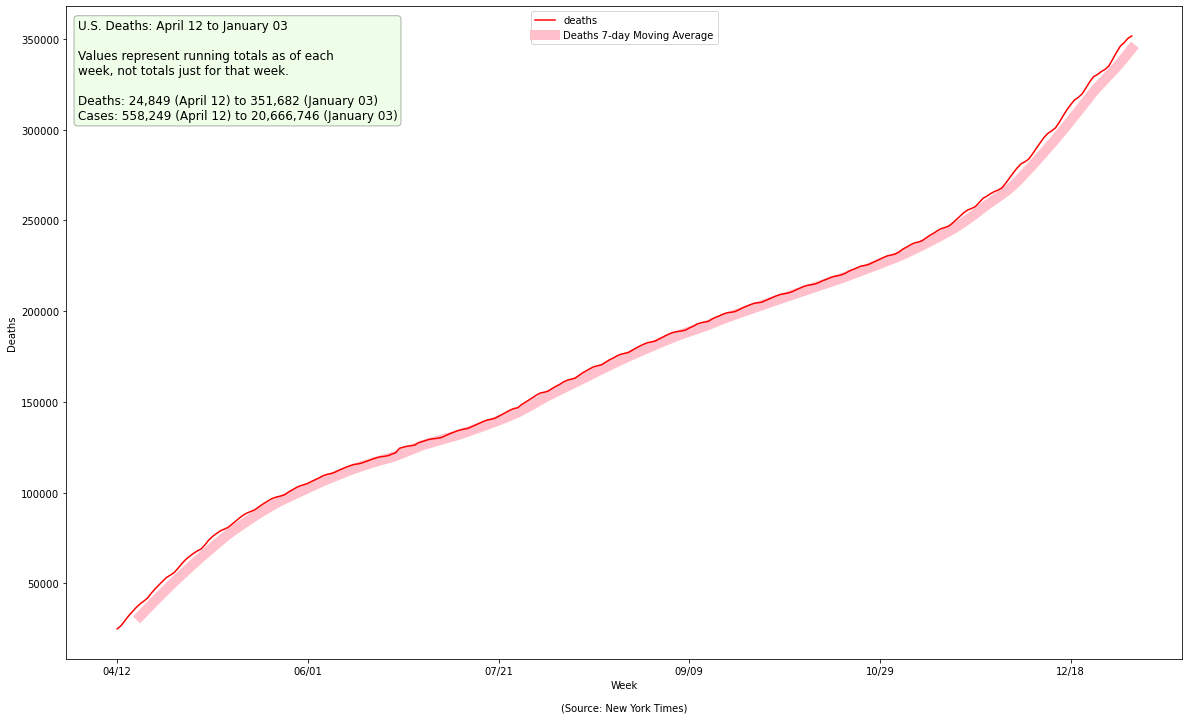

In [14]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='nyt-us-deaths.png', textbox_heading="U.S. Deaths");

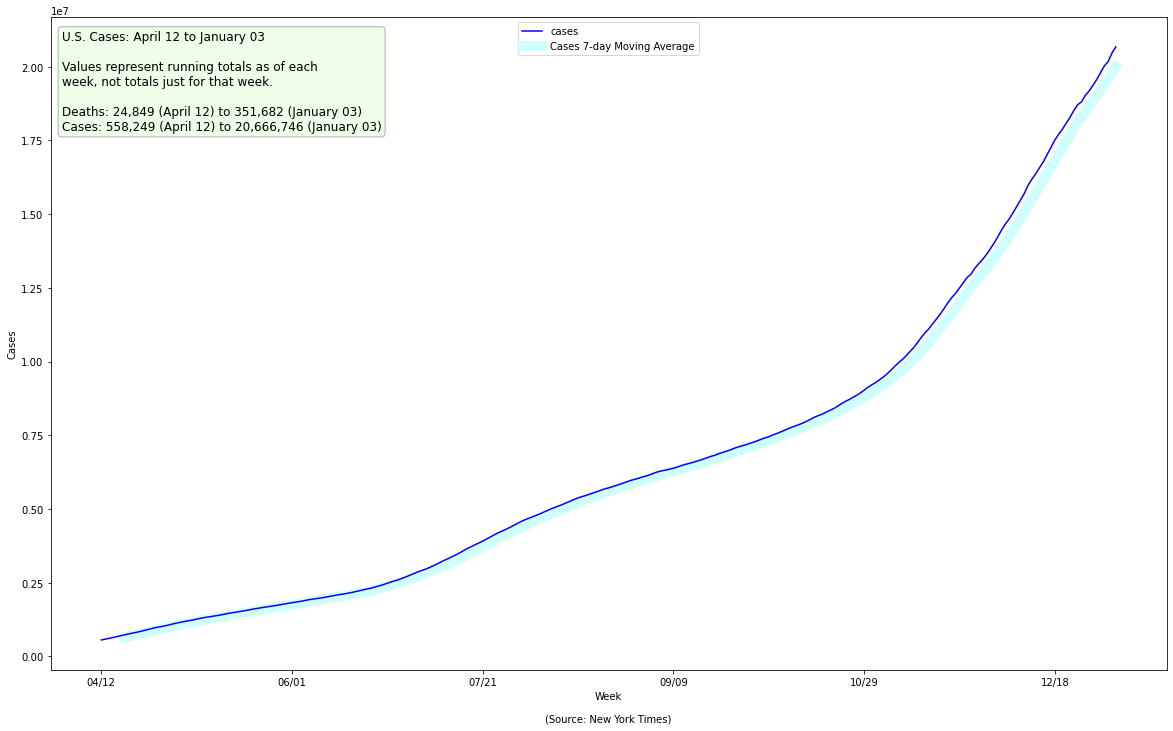

In [15]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='nyt-us-cases.png', textbox_heading="U.S. Cases");

#### Just the past week

In [16]:
week_delta = timedelta(days=6)
six_days_prior = end_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(end_date, hour=23, minute=59, second=59)

df_past_week = df_states.loc[(df_states.date >= last_week_start) & (df_states.date <= last_week_end)]

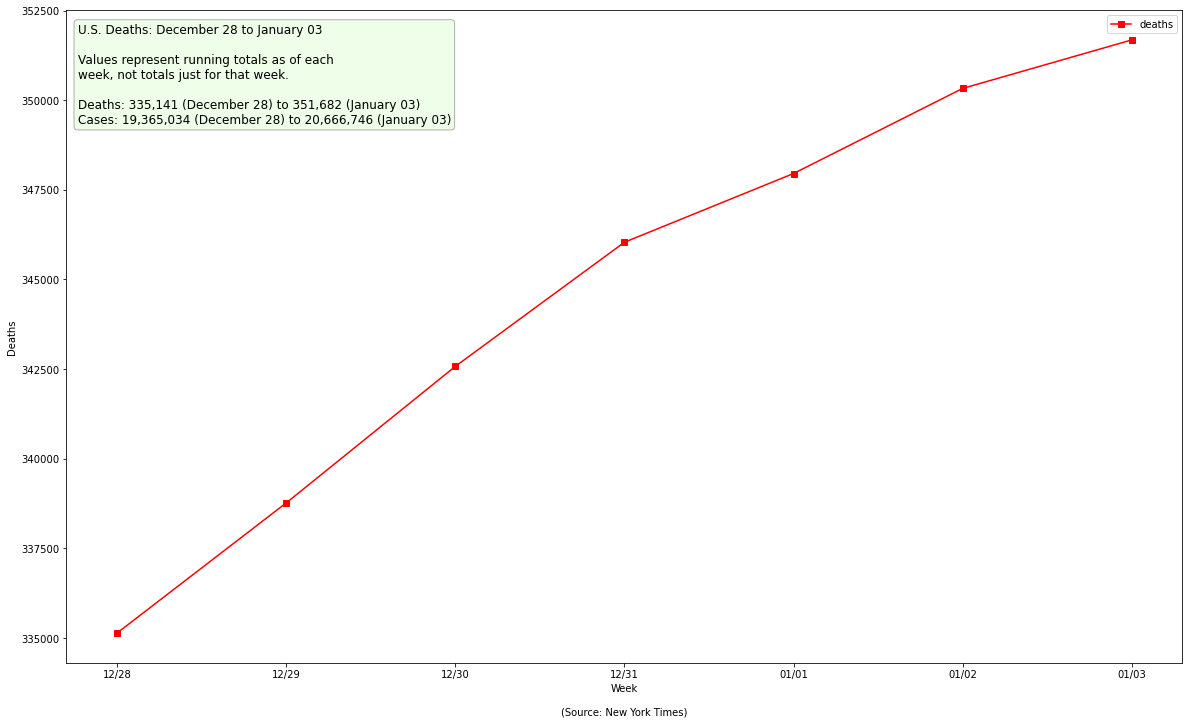

In [17]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='nyt-us-deaths-past-week.png');

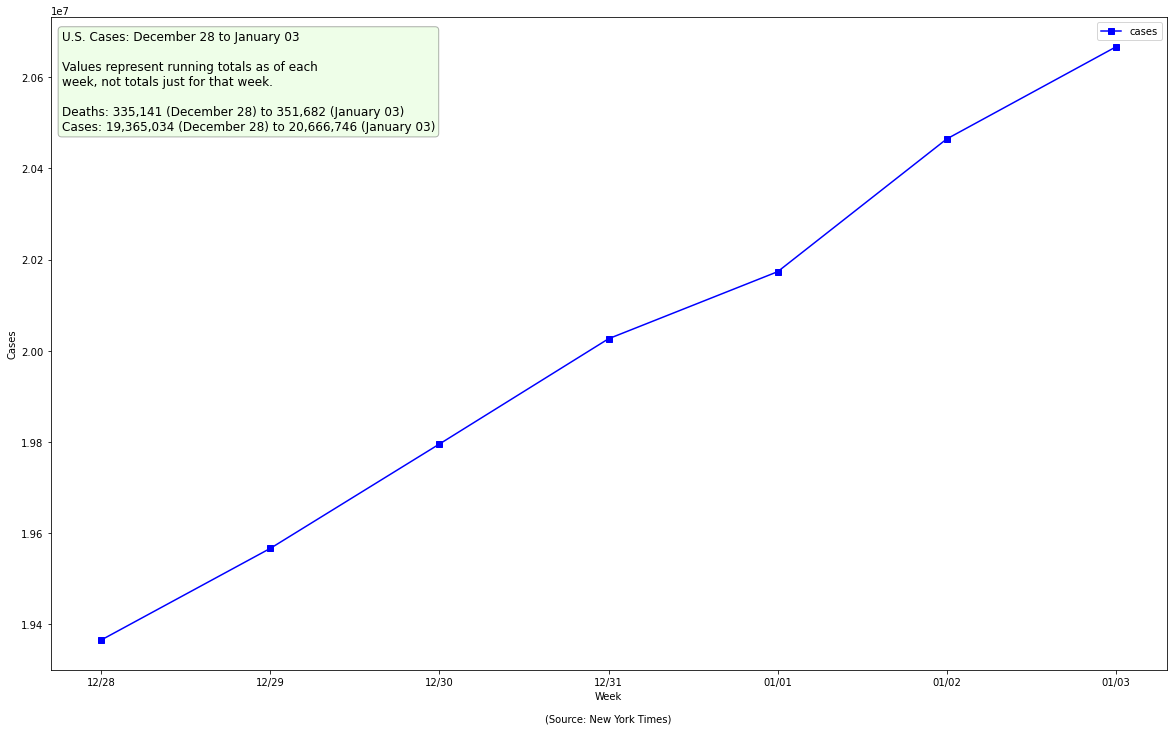

In [18]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.CASES}, marker='s', 
                   textbox_heading="U.S. Cases", image_file='nyt-us-cases-past-week.png');

#### Daily values, instead of cumulative values

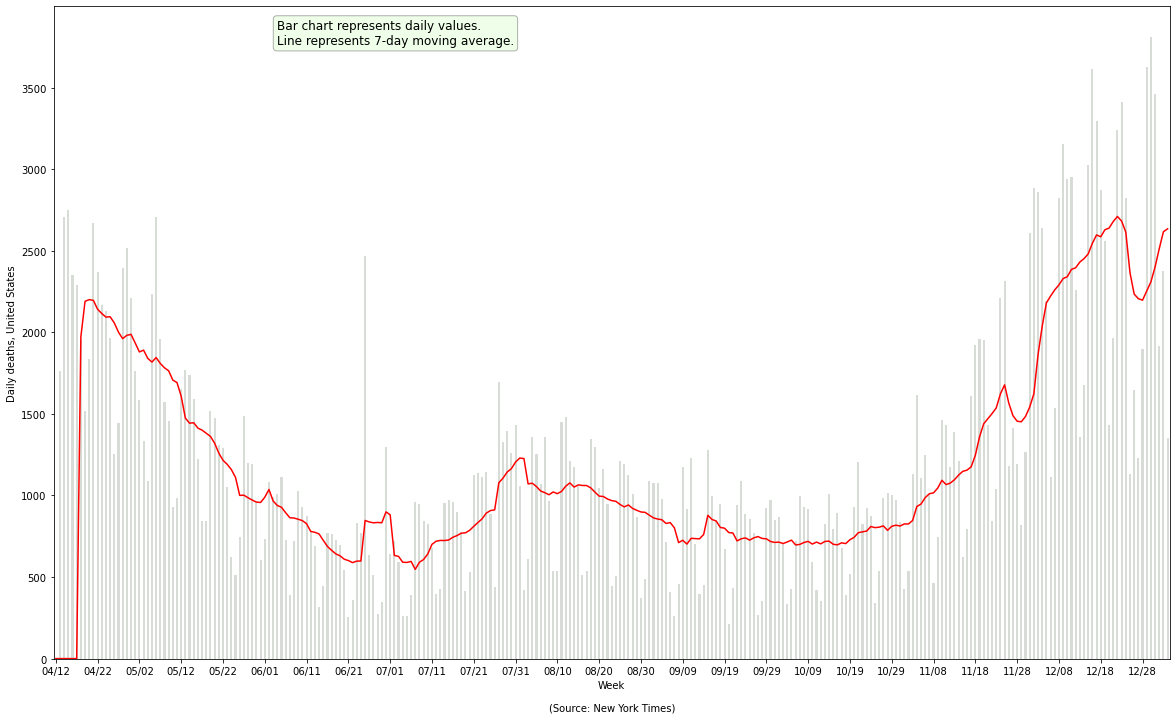

In [19]:
fig, ax, deaths_df_with_diffs = plot_daily_stats(df_states, 
                                                 source=SOURCE,
                                                 metric=MetricType.DEATHS,
                                                 region='United States',
                                                 moving_average=True,
                                                 image_file="nyt-us-deaths-daily.png",
                                                 textbox_loc=(0.20, 0.98))

In [20]:
max_date = deaths_df_with_diffs.date.max()
deaths_df_with_diffs.loc[deaths_df_with_diffs.date == max_date]

date     cases  deaths  hospitalizations  recoveries  tests  \
266 2021-01-03  20666746  351682                 0           0      0   

            region month_day    diff      diff_ma  
266  United States     01/03  1353.0  2634.285714

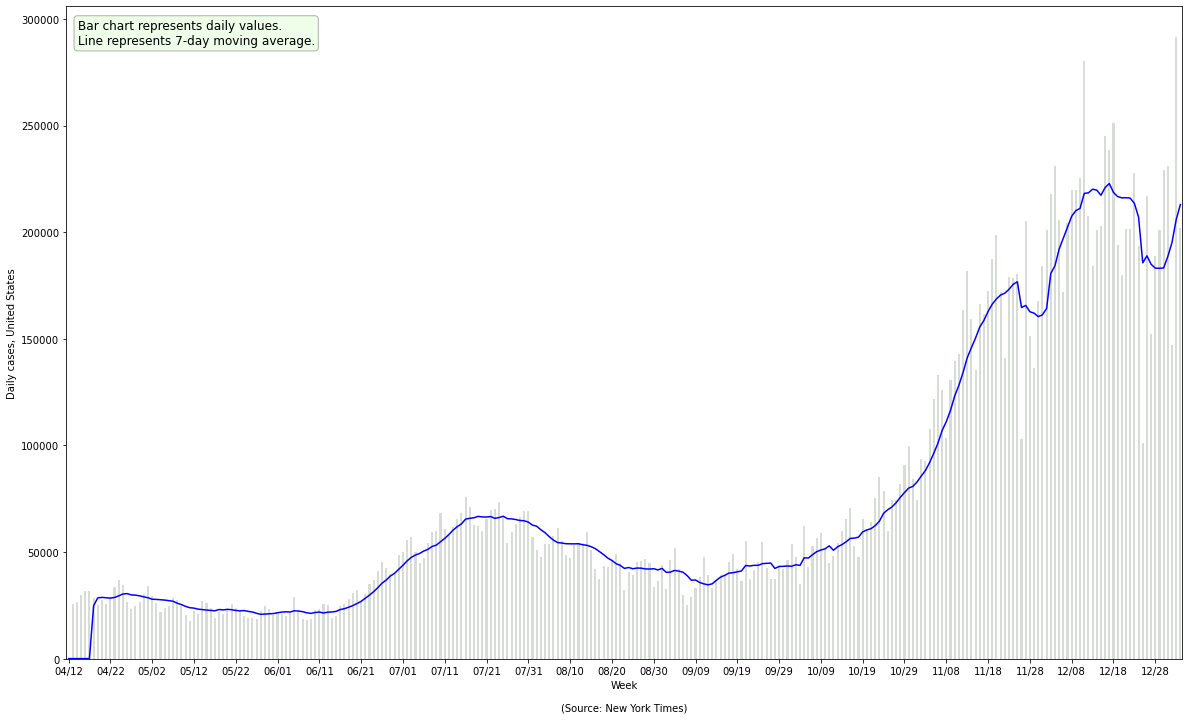

In [21]:
fig, ax, cases_df_with_diffs = plot_daily_stats(df_states, 
                                                source=SOURCE,
                                                metric=MetricType.CASES,
                                                region='United States',
                                                moving_average=True,
                                                image_file="nyt-us-cases-daily.png")

In [22]:
max_date = cases_df_with_diffs.date.max()
cases_df_with_diffs.loc[cases_df_with_diffs.date == max_date]

date     cases  deaths  hospitalizations  recoveries  tests  \
266 2021-01-03  20666746  351682                 0           0      0   

            region month_day      diff        diff_ma  
266  United States     01/03  201980.0  212965.142857

#### Deaths vs. Cases

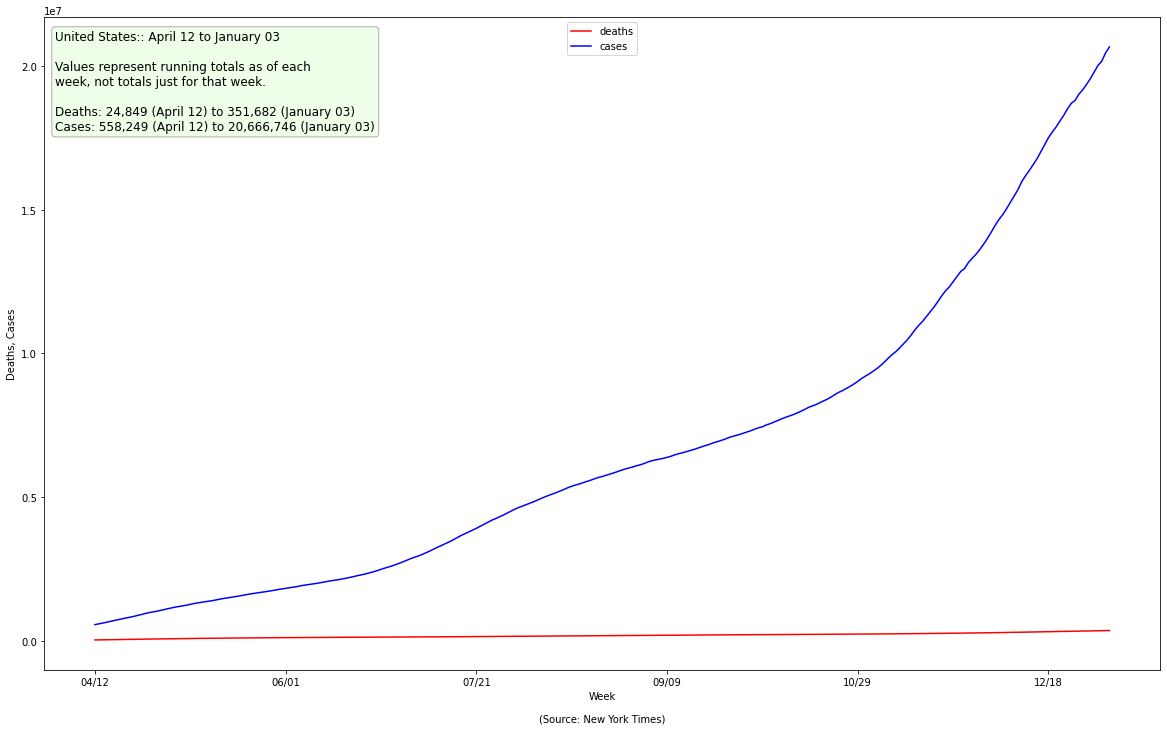

In [23]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="nyt-us-deaths-and-cases.png");

### Individual States

#### Pennsylvania

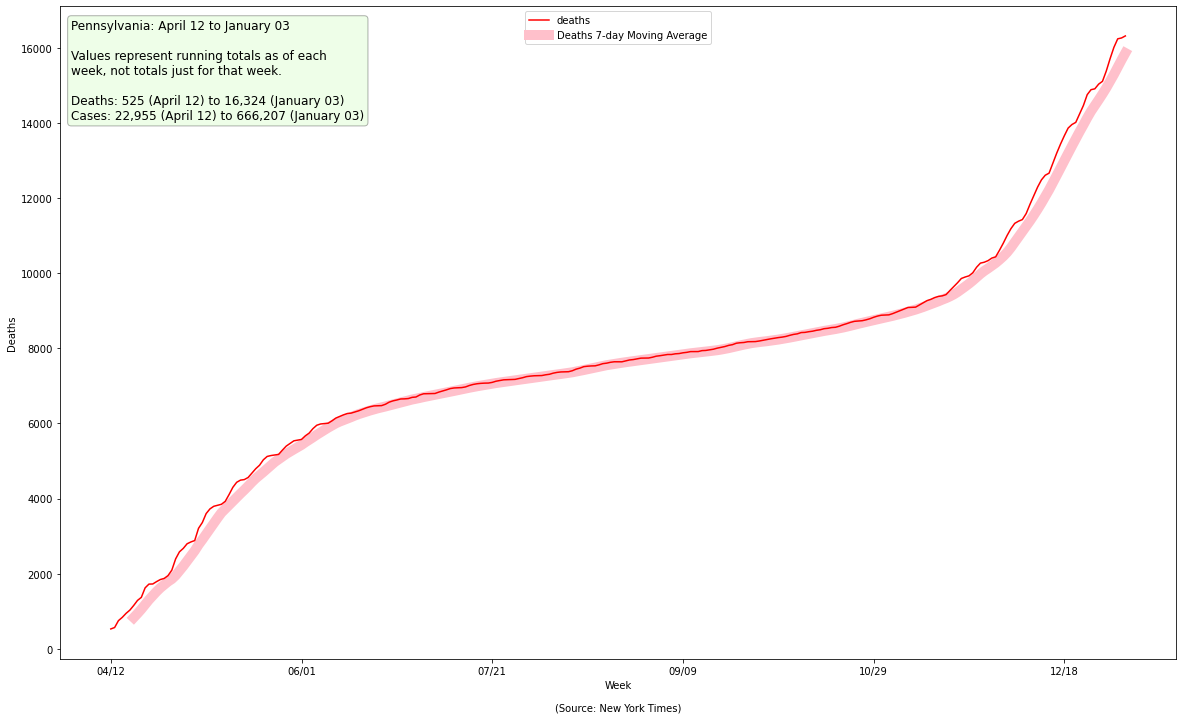

In [24]:
plot_state(df_states, SOURCE, 'Pennsylvania', moving_average=True,
           image_file='nyt-pa-deaths.png', metrics={MetricType.DEATHS});

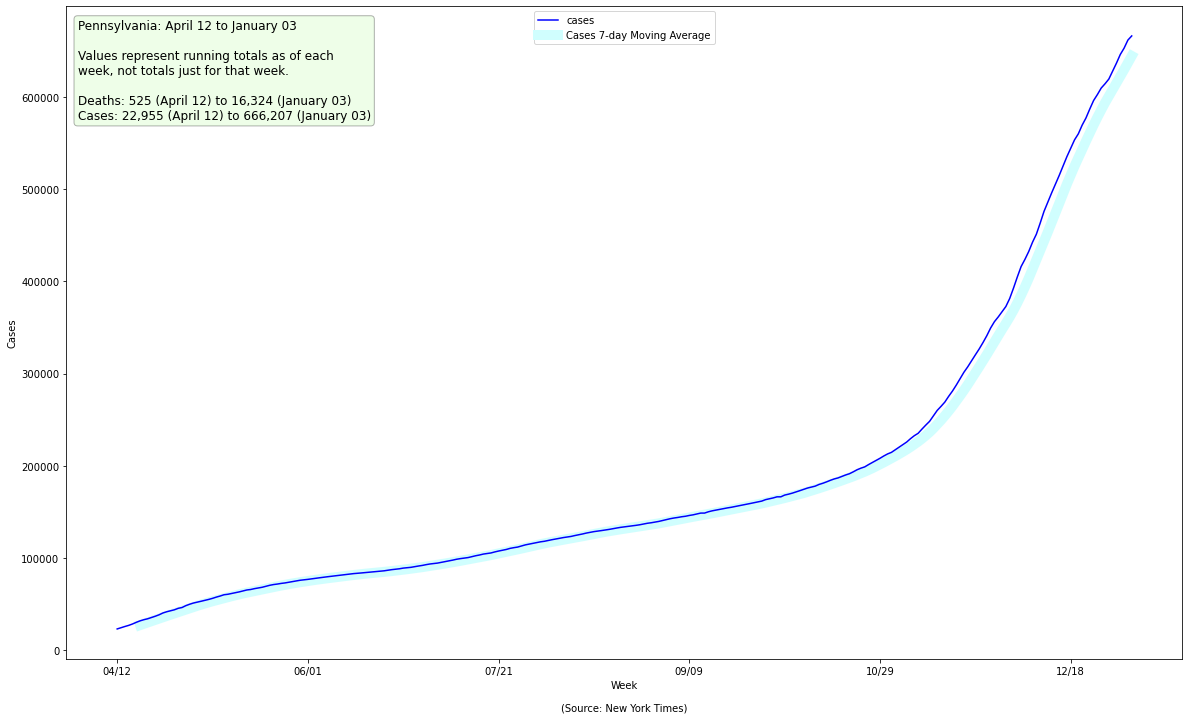

In [25]:
plot_state(df_states, SOURCE, 'Pennsylvania', moving_average=True,
           image_file='nyt-pa-cases.png', metrics={MetricType.CASES});

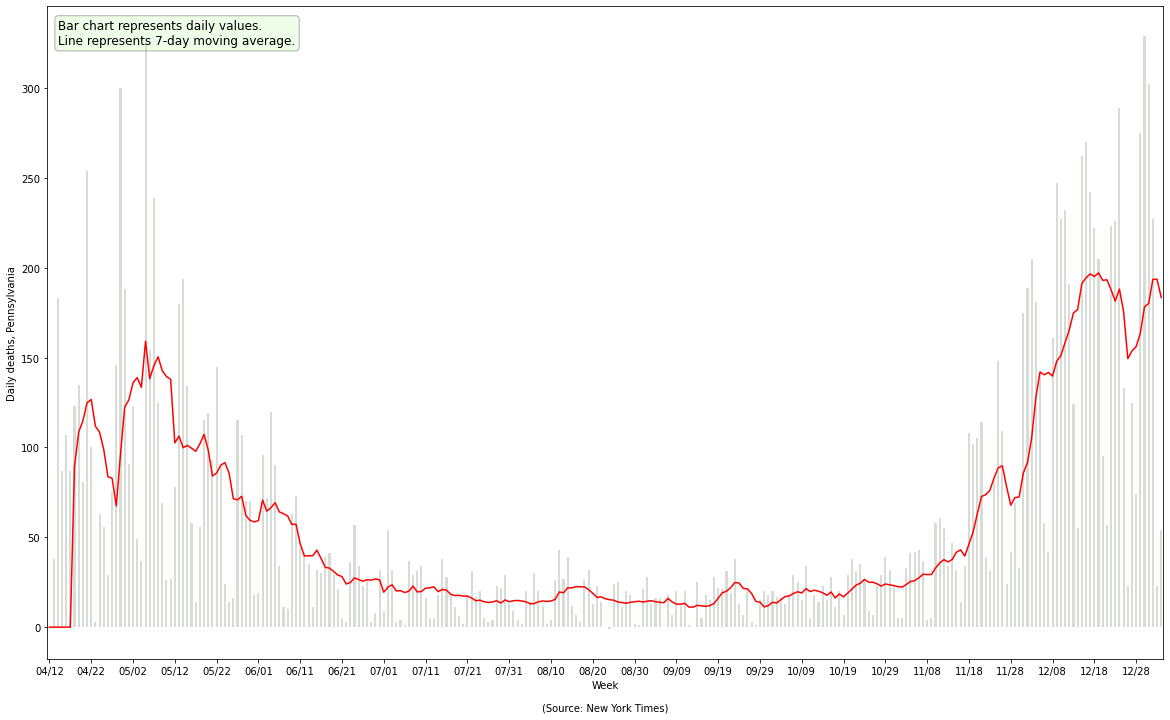

In [26]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="nyt-pa-deaths-daily.png");

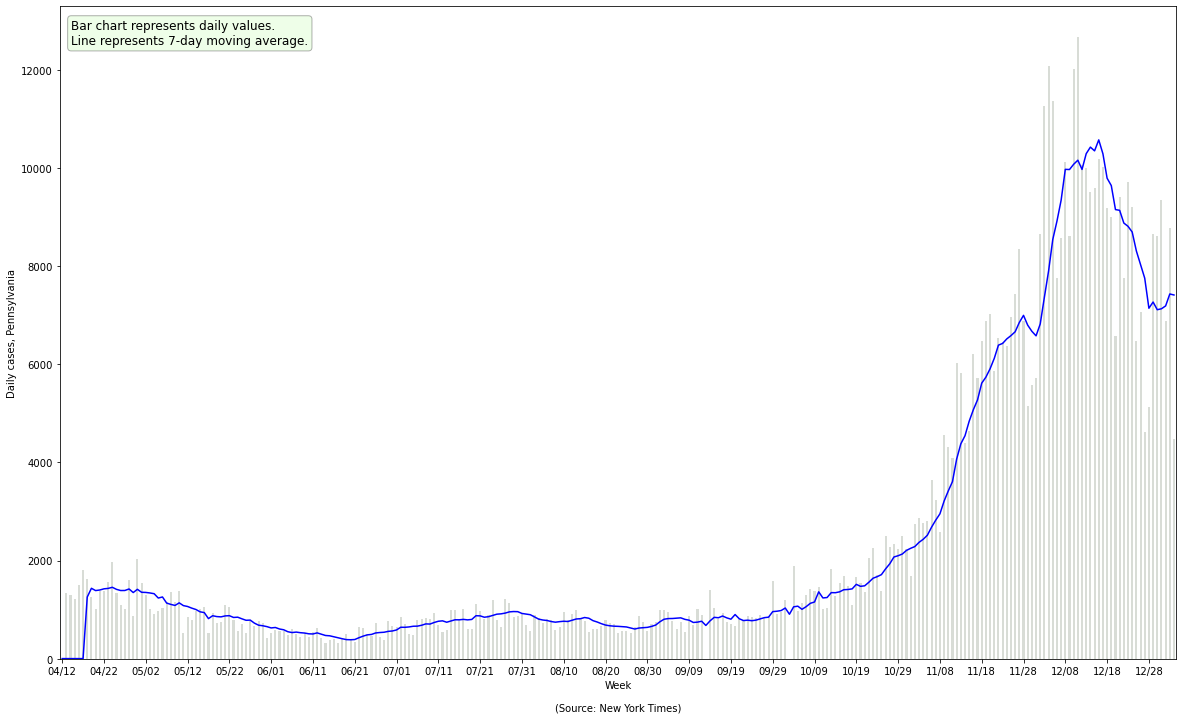

In [27]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="nyt-pa-cases-daily.png");

#### New York

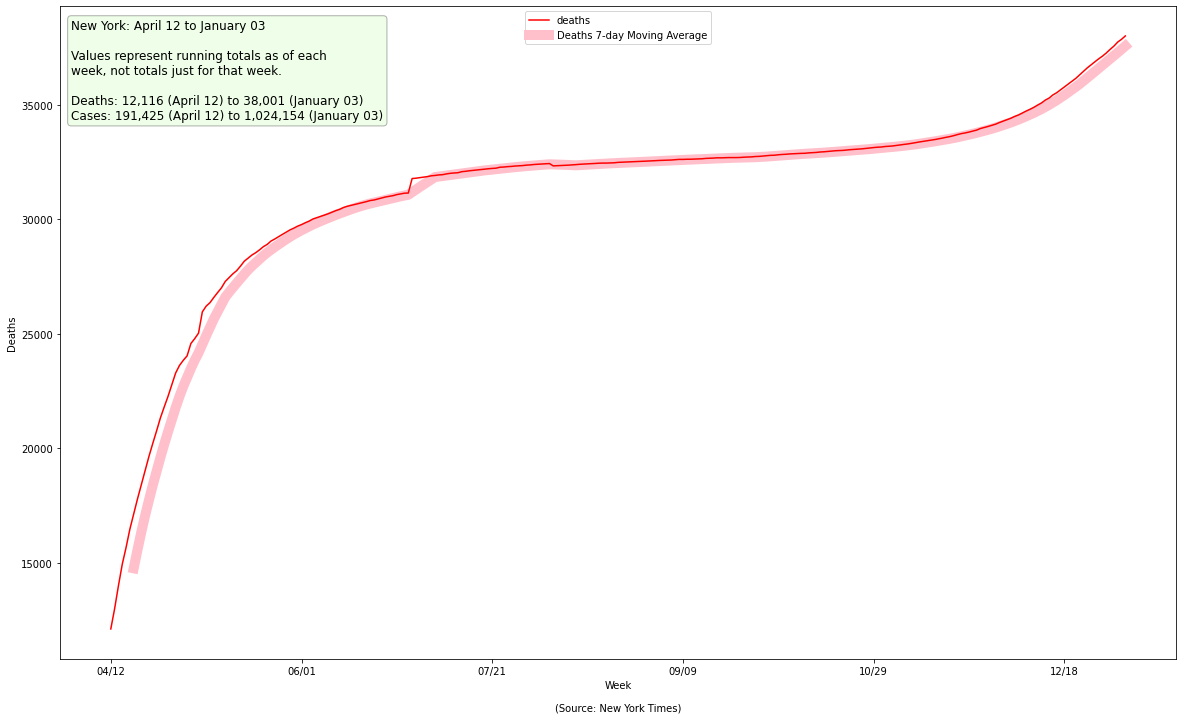

In [28]:
plot_state(df_states, SOURCE, 'New York', moving_average=True,
           image_file='nyt-ny-deaths.png', metrics={MetricType.DEATHS});

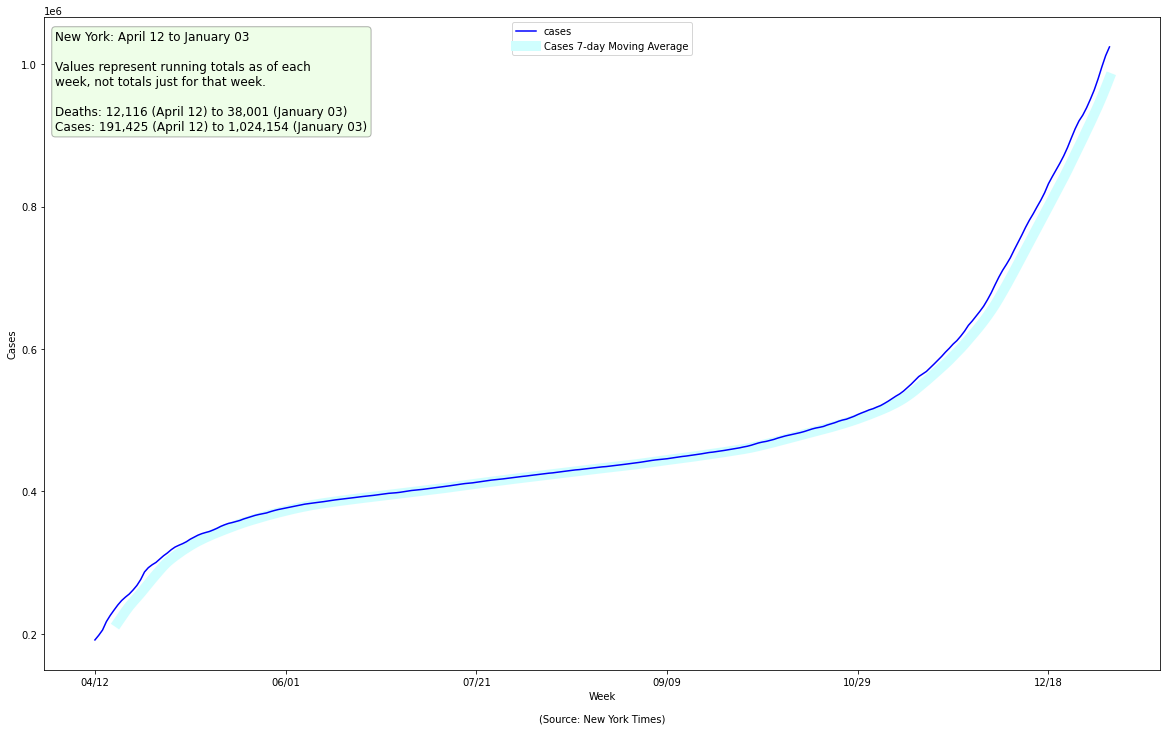

In [29]:
plot_state(df_states, SOURCE, 'New York', moving_average=True,
           image_file='nyt-ny-cases.png', metrics={MetricType.CASES});

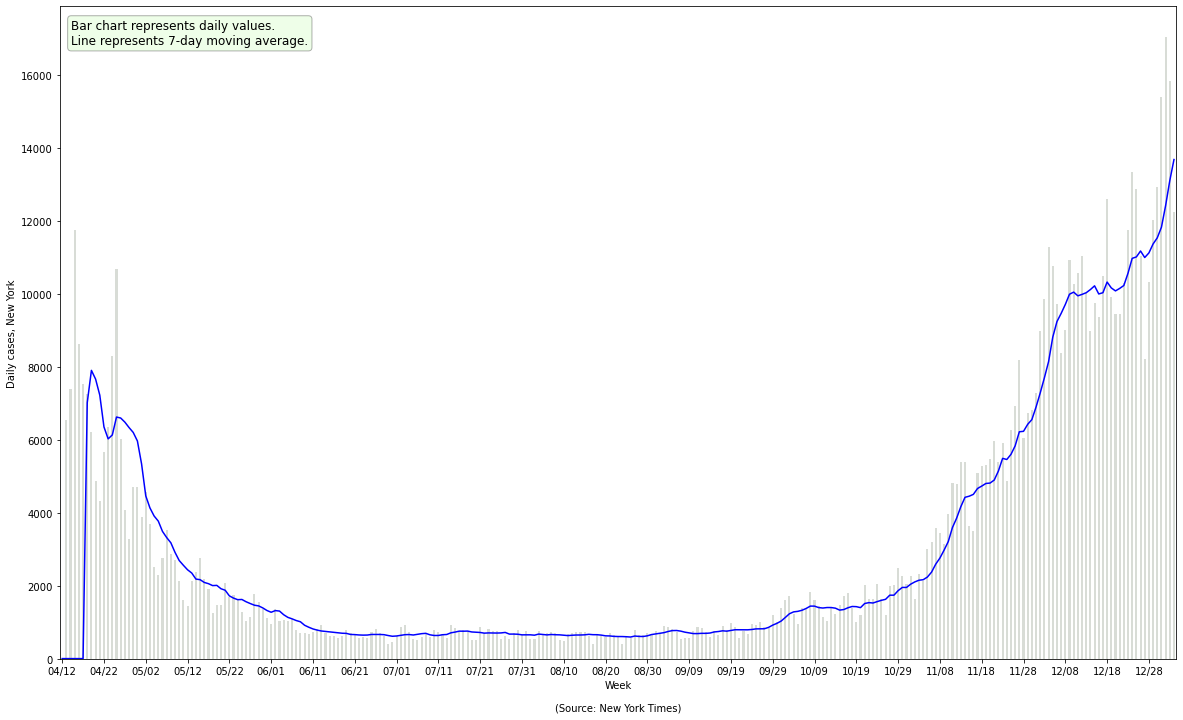

In [30]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='New York',
                 moving_average=True,
                 image_file="nyt-ny-cases-daily.png");

#### New Jersey

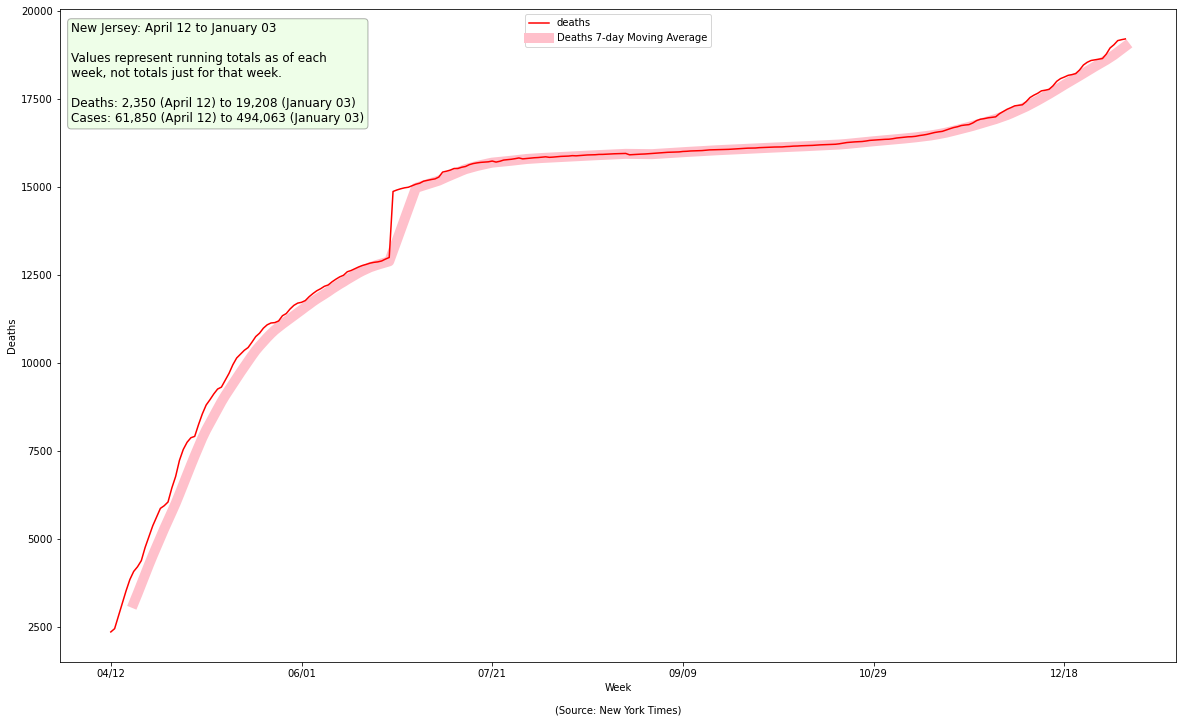

In [31]:
plot_state(df_states, SOURCE, 'New Jersey', moving_average=True,
           image_file='nyt-nj-deaths.png', metrics={MetricType.DEATHS});

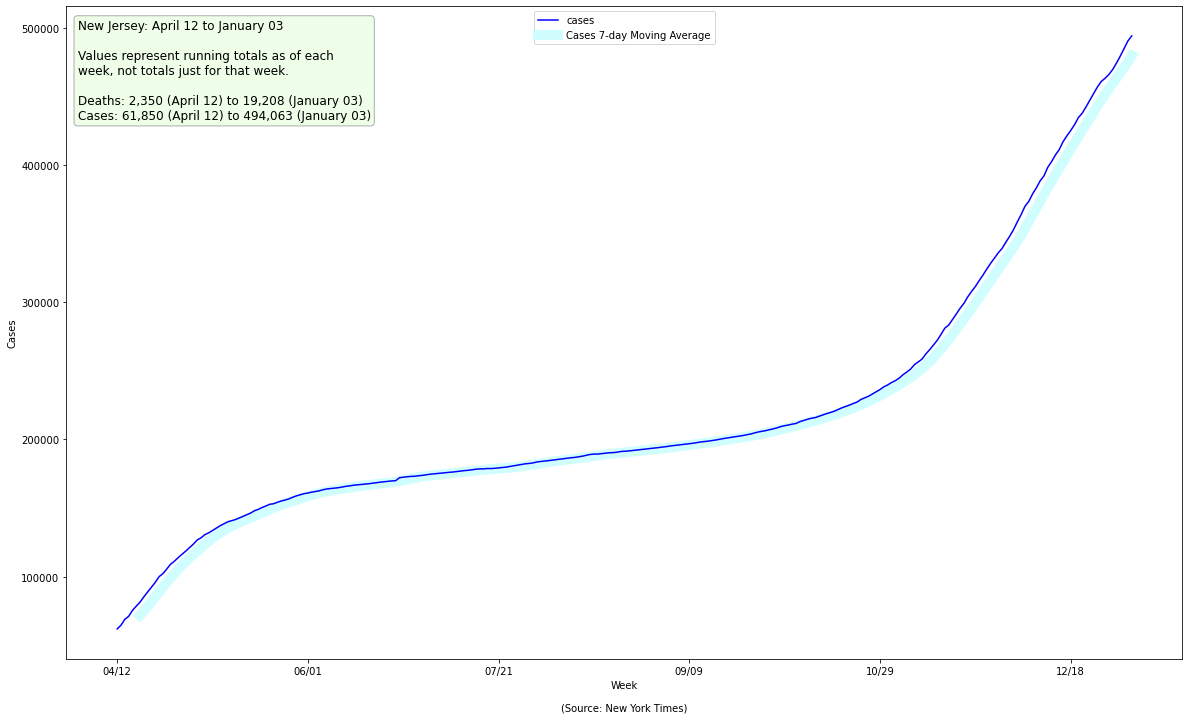

In [32]:
plot_state(df_states, SOURCE, 'New Jersey', moving_average=True,
           image_file='nyt-nj-cases.png', metrics={MetricType.CASES});

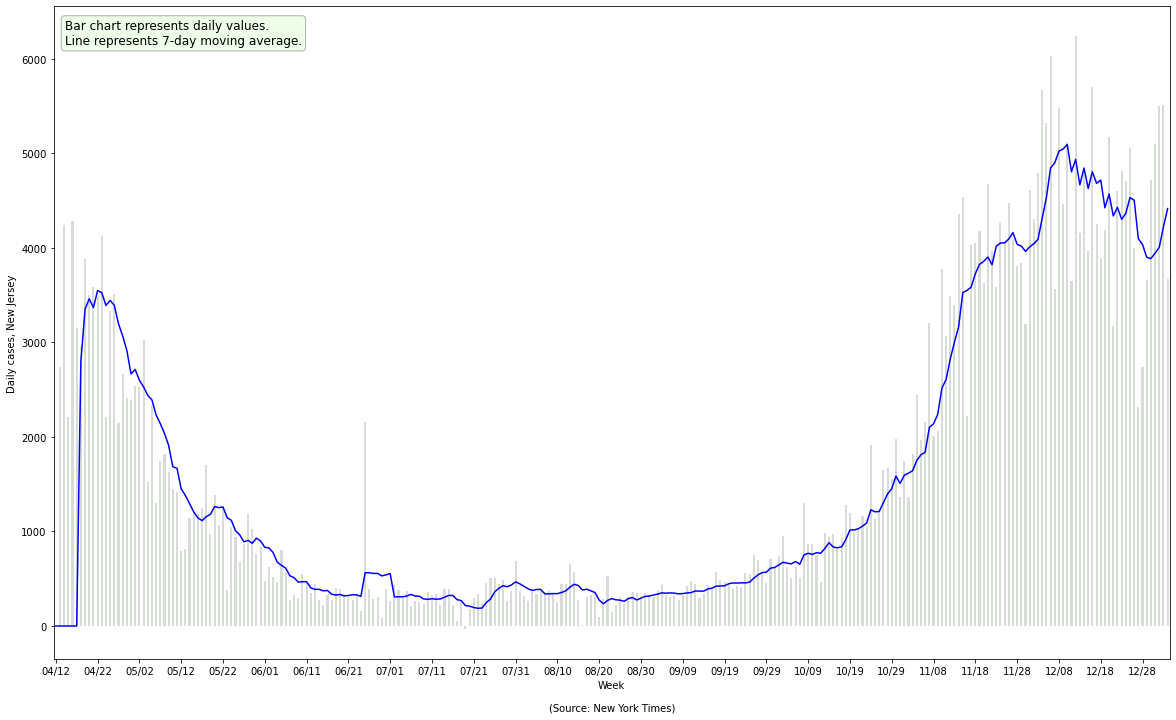

In [33]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='New Jersey',
                 moving_average=True,
                 image_file="nyt-nj-cases-daily.png");

#### Washington

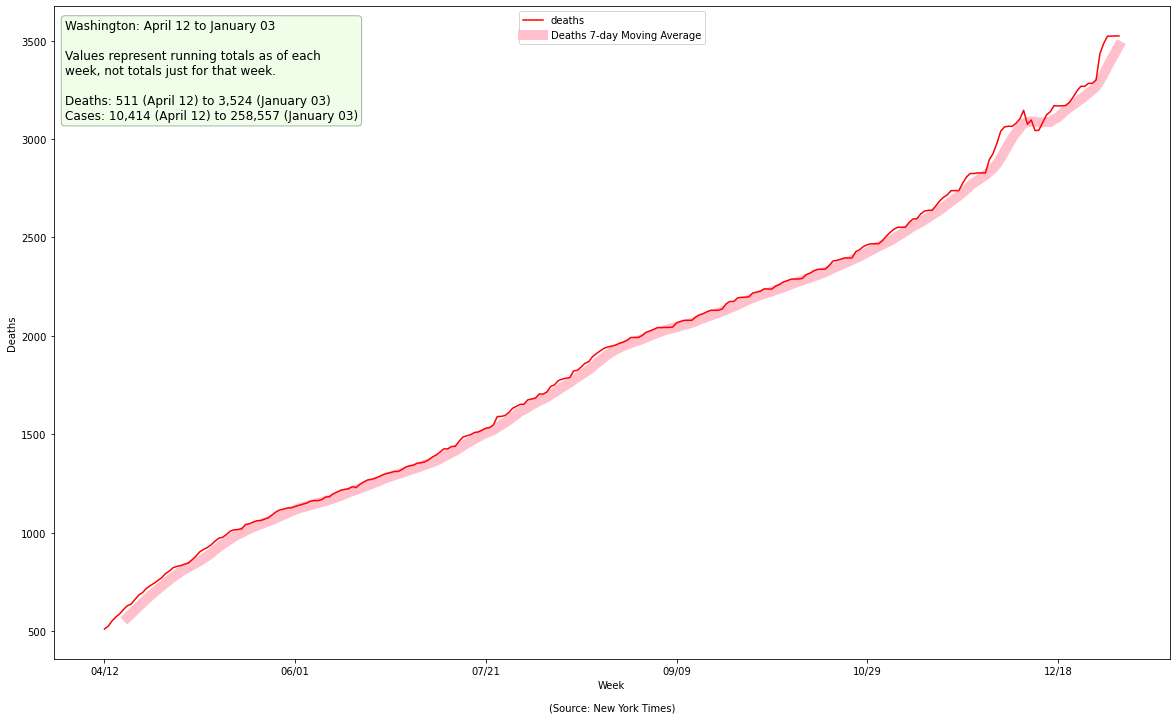

In [34]:
plot_state(df_states, SOURCE, 'Washington', moving_average=True,
           image_file='nyt-wa-deaths.png', metrics={MetricType.DEATHS});

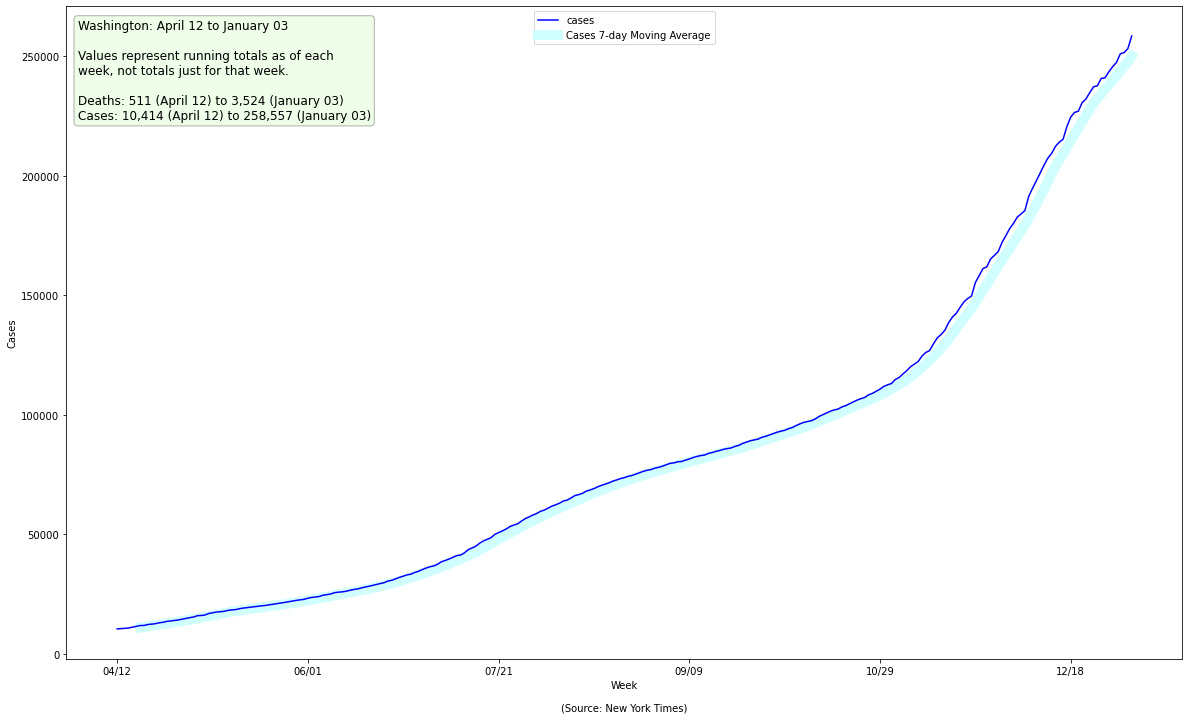

In [35]:
plot_state(df_states, SOURCE, 'Washington', moving_average=True,
           image_file='nyt-wa-cases.png', metrics={MetricType.CASES});

#### Delaware

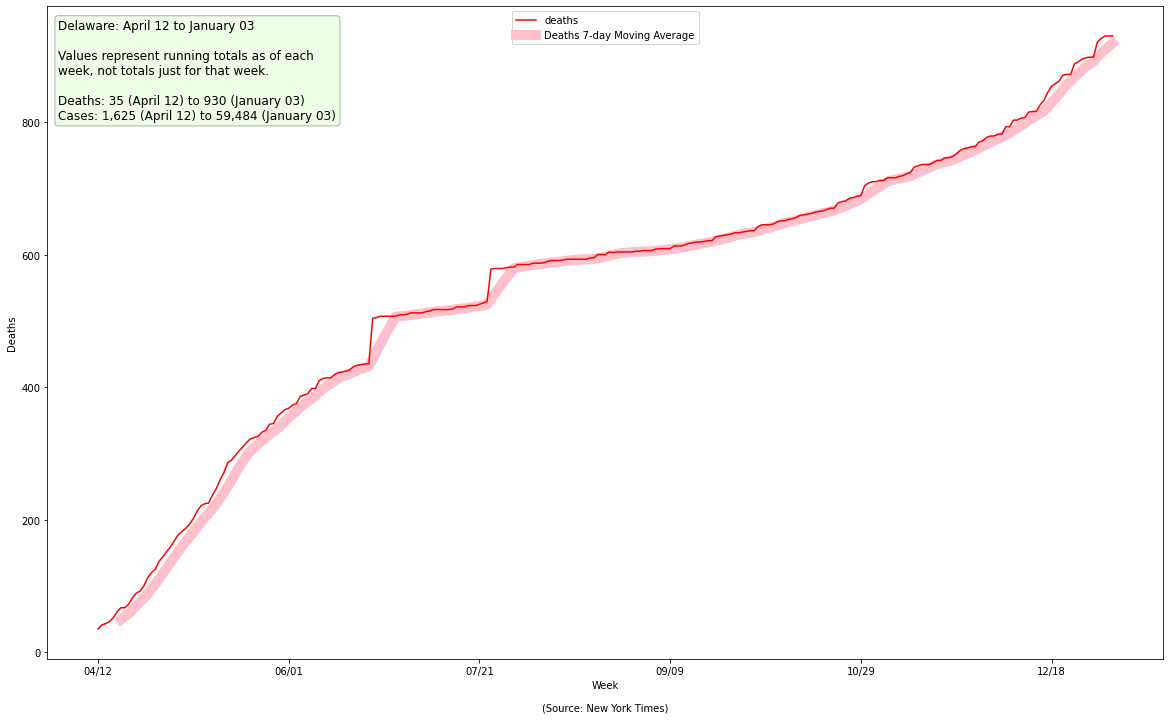

In [36]:
plot_state(df_states, SOURCE, 'Delaware', moving_average=True,
           image_file='nyt-de-deaths.png', metrics={MetricType.DEATHS});

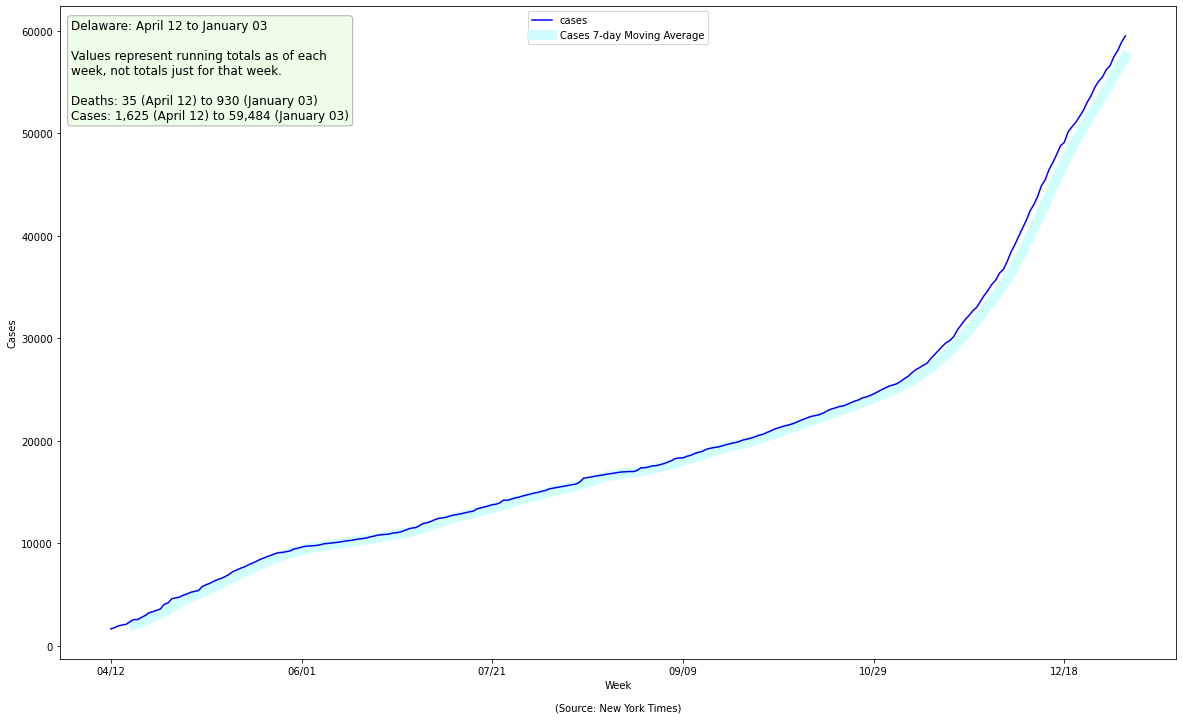

In [37]:
plot_state(df_states, SOURCE, 'Delaware', moving_average=True,
           image_file='nyt-de-cases.png', metrics={MetricType.CASES});

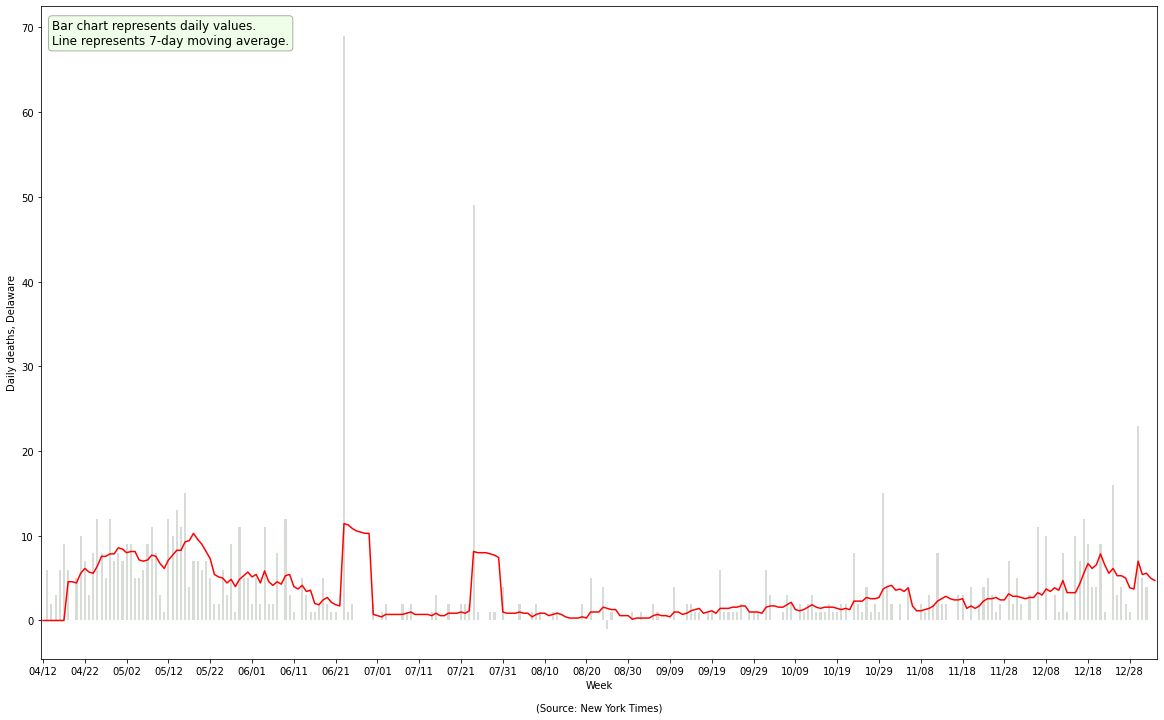

In [38]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Delaware',
                 moving_average=True,
                 image_file="jhu-de-deaths-daily.png");

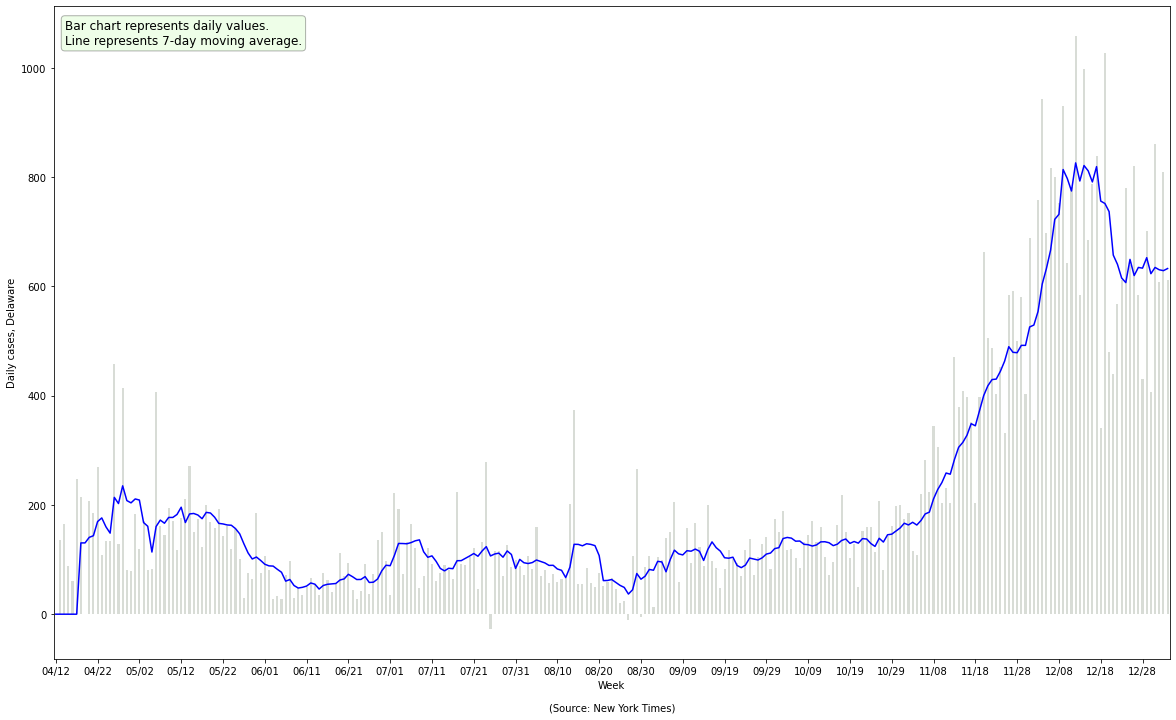

In [39]:
plot_daily_stats(df_states, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Delaware',
                 moving_average=True,
                 image_file="jhu-de-cases-daily.png");

#### Texas

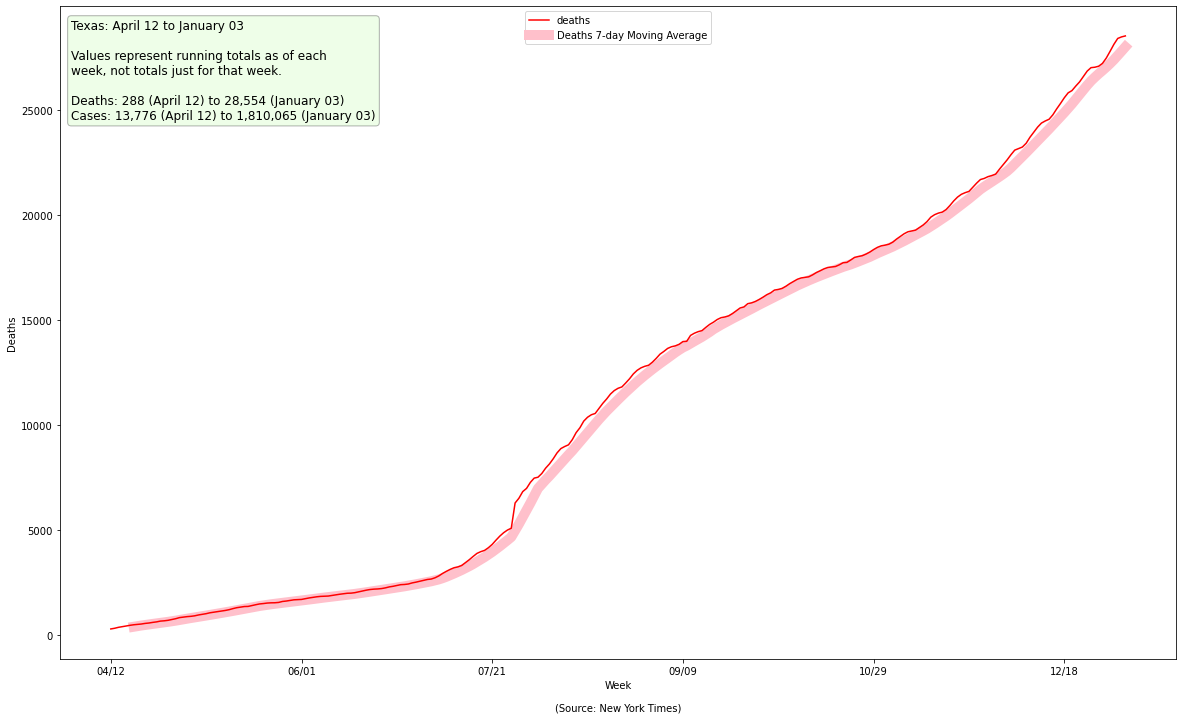

In [40]:
plot_state(df_states, SOURCE, 'Texas', moving_average=True,
           image_file='nyt-tx-deaths.png', metrics={MetricType.DEATHS});

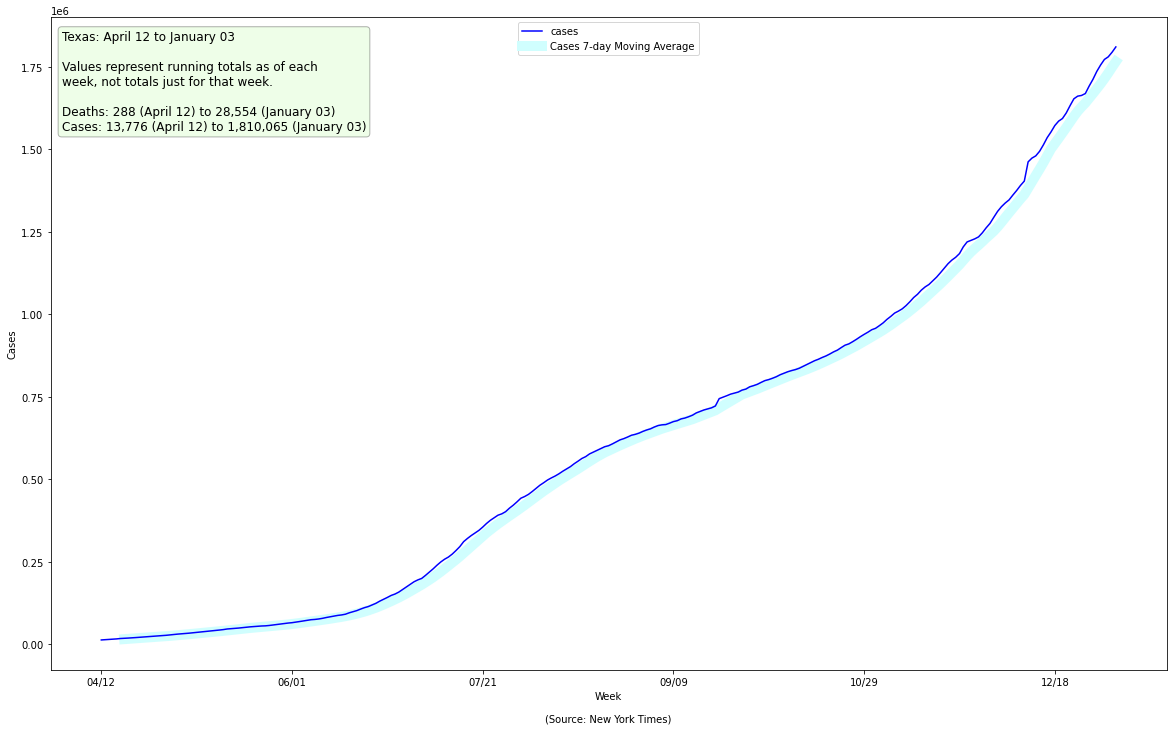

In [41]:
plot_state(df_states, SOURCE, 'Texas', moving_average=True,
           image_file='nyt-tx-cases.png', metrics={MetricType.CASES});

#### Georgia

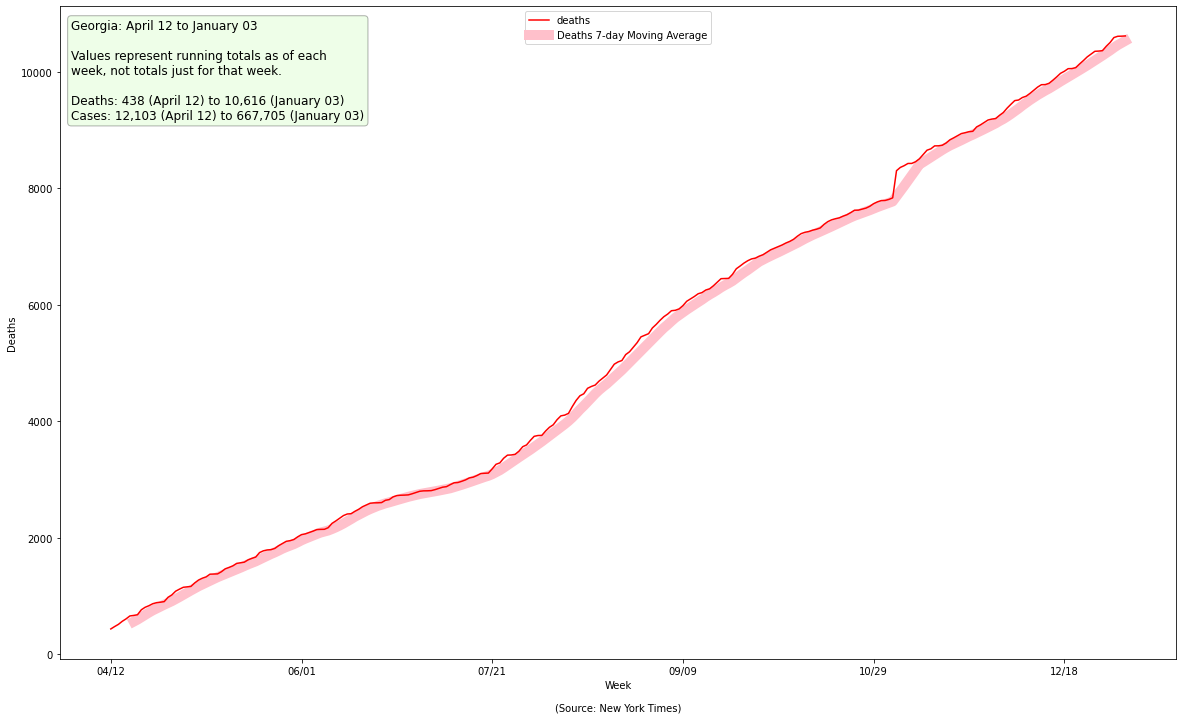

In [42]:
plot_state(df_states, SOURCE, 'Georgia', moving_average=True,
           image_file='nyt-ga-deaths.png', metrics={MetricType.DEATHS});

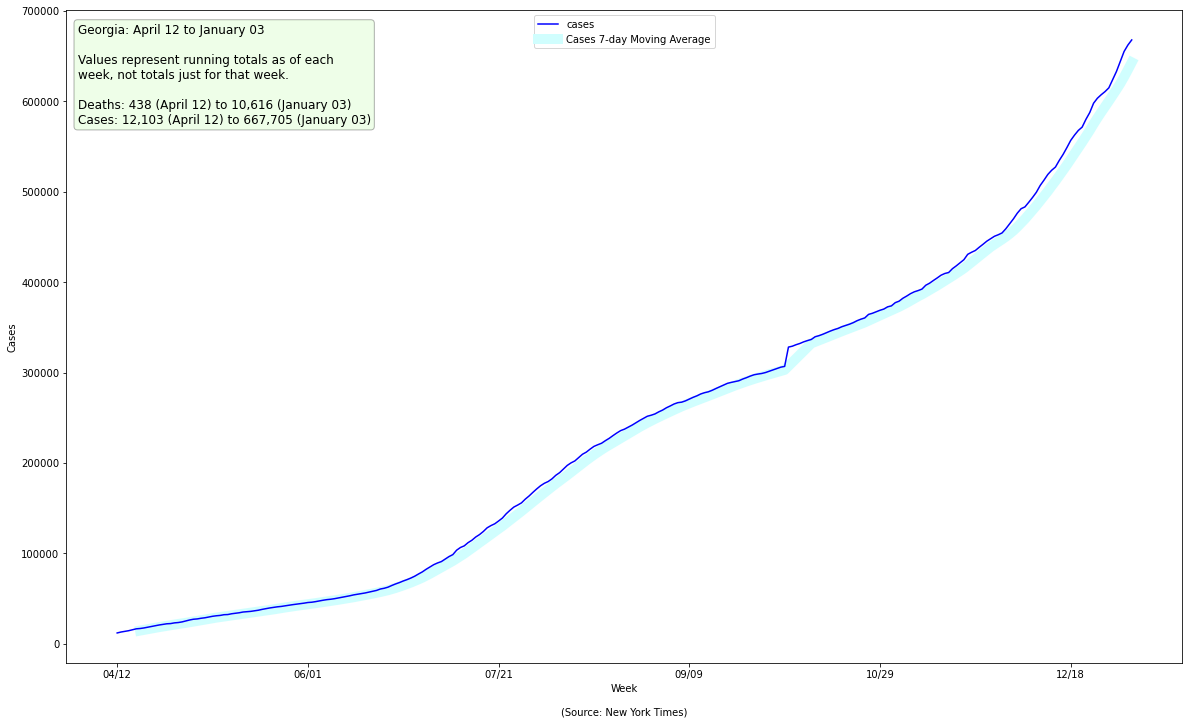

In [43]:
plot_state(df_states, SOURCE, 'Georgia', moving_average=True,
           image_file='nyt-ga-cases.png', metrics={MetricType.CASES});

#### Mississippi

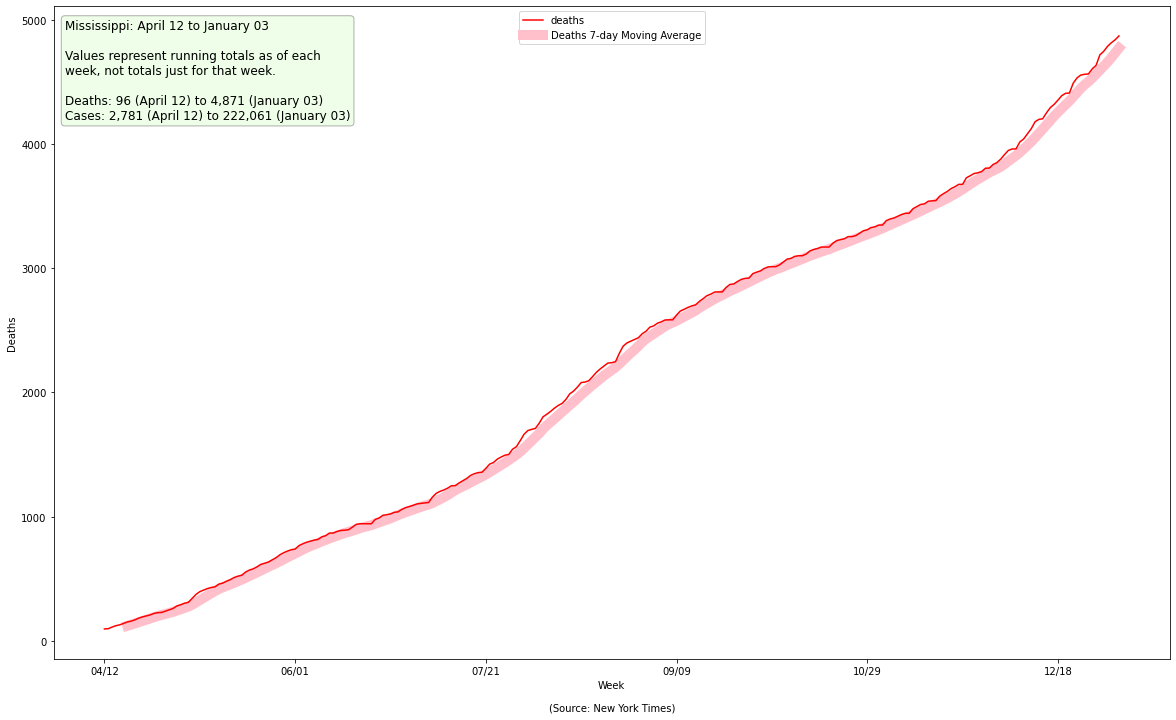

In [44]:
plot_state(df_states, SOURCE, 'Mississippi', moving_average=True,
           image_file='nyt-ms-deaths.png', metrics={MetricType.DEATHS});

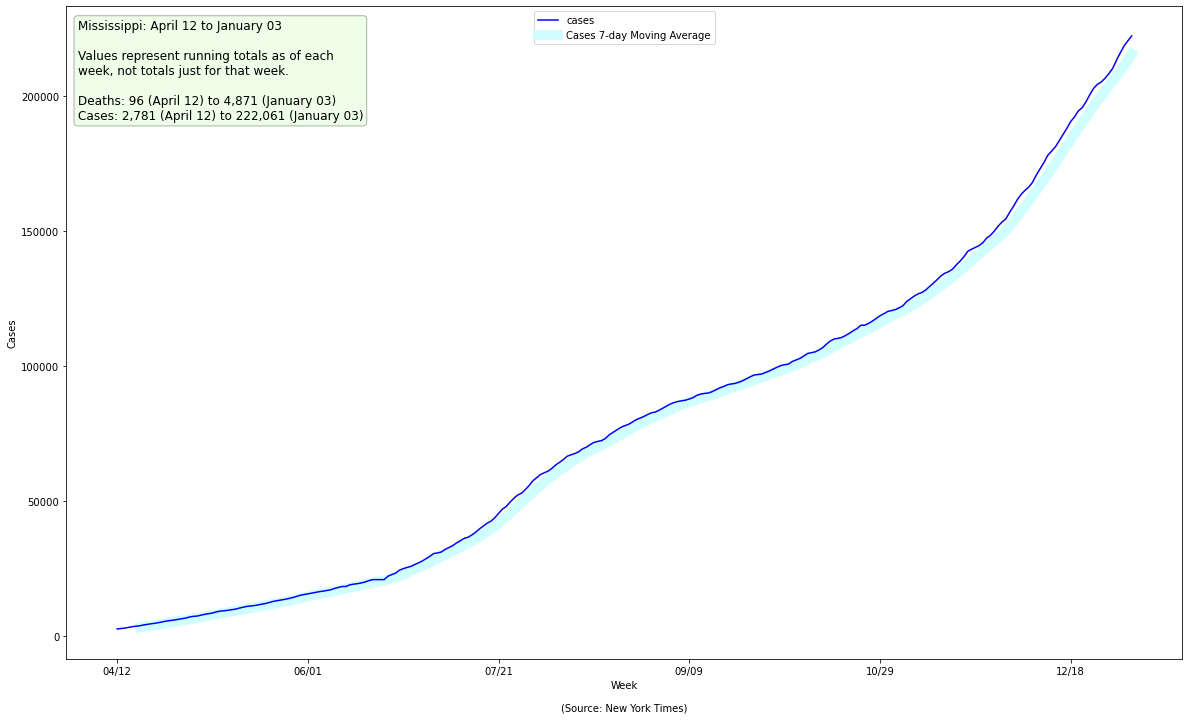

In [45]:
plot_state(df_states, SOURCE, 'Mississippi', moving_average=True,
           image_file='nyt-ms-cases.png', metrics={MetricType.CASES});

#### Arizona

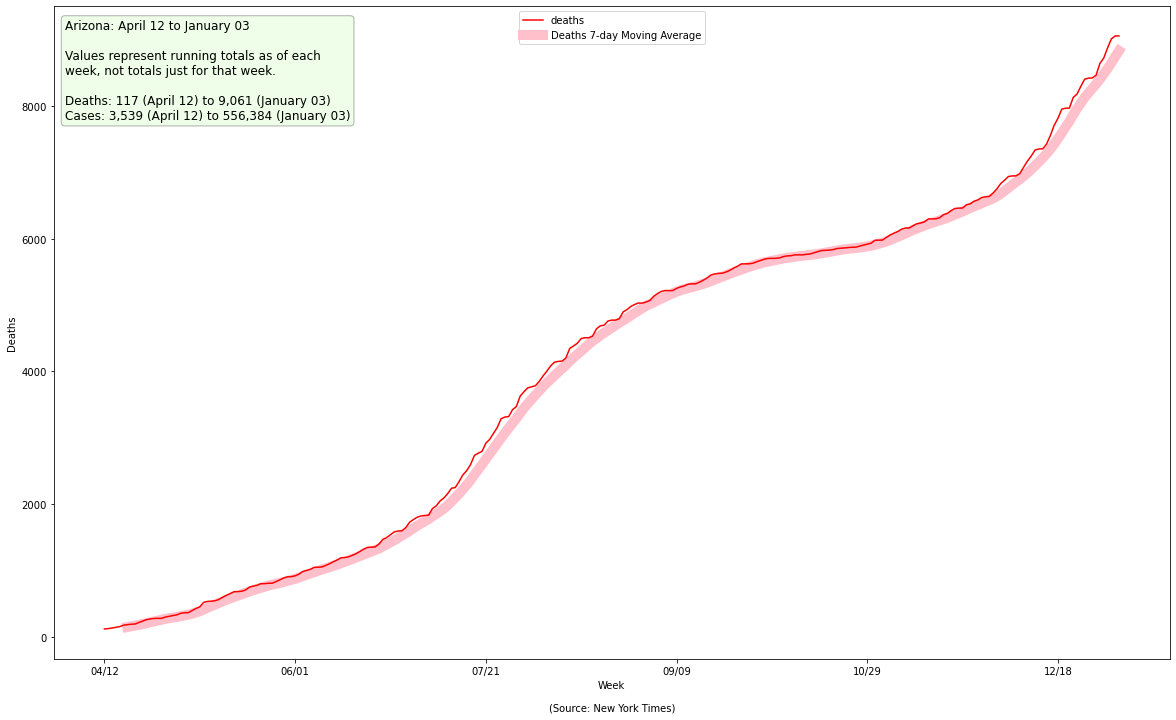

In [46]:
plot_state(df_states, SOURCE, 'Arizona', moving_average=True,
           image_file='nyt-az-deaths.png', metrics={MetricType.DEATHS});

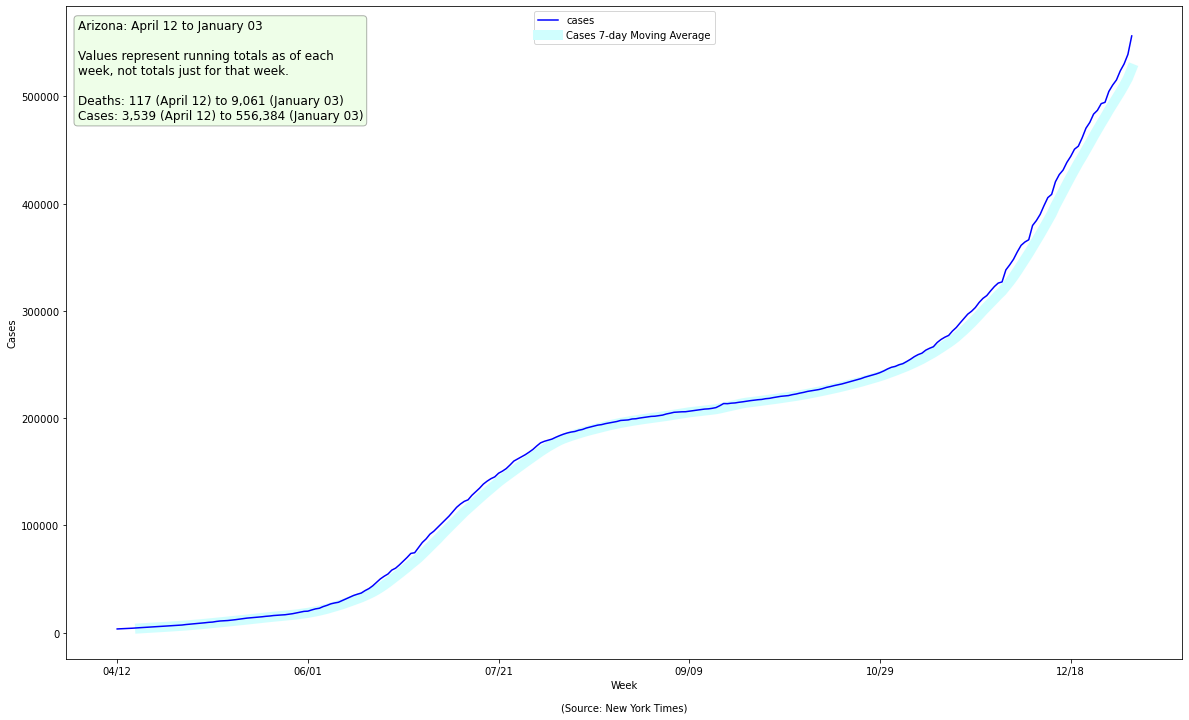

In [47]:
plot_state(df_states, SOURCE, 'Arizona', moving_average=True,
           image_file='nyt-az-cases.png', metrics={MetricType.CASES});

#### Florida

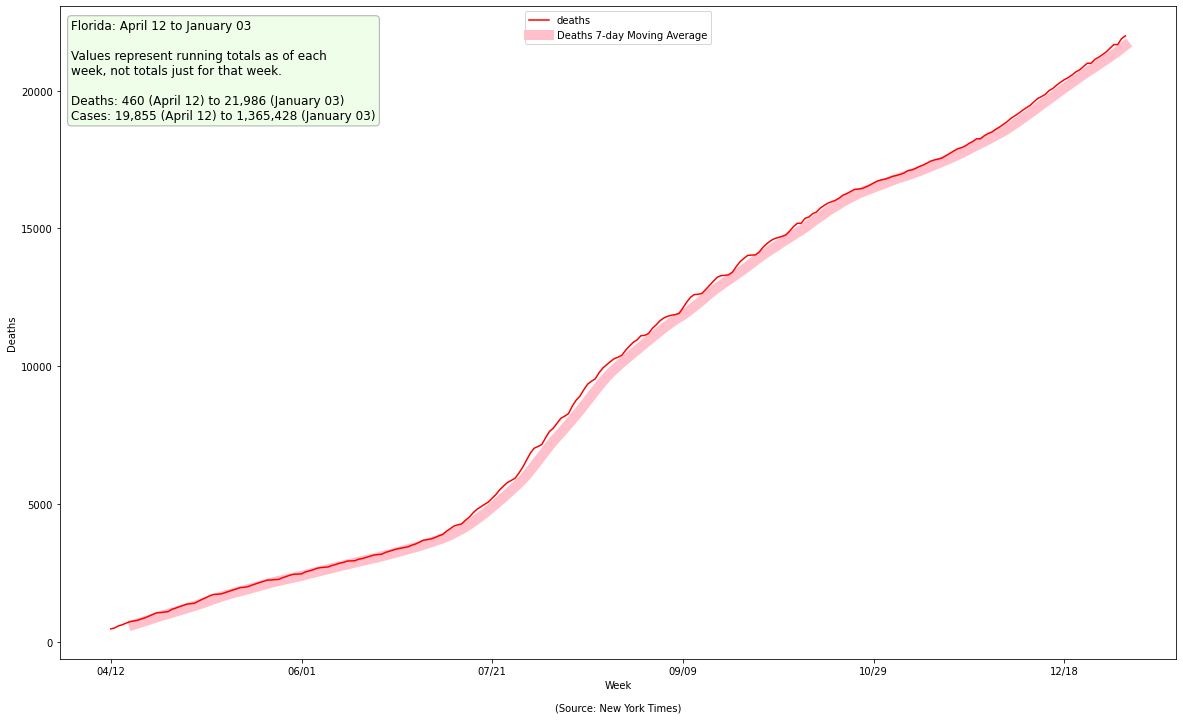

In [48]:
plot_state(df_states, SOURCE, 'Florida', moving_average=True,
           image_file='nyt-fl-deaths.png', metrics={MetricType.DEATHS});

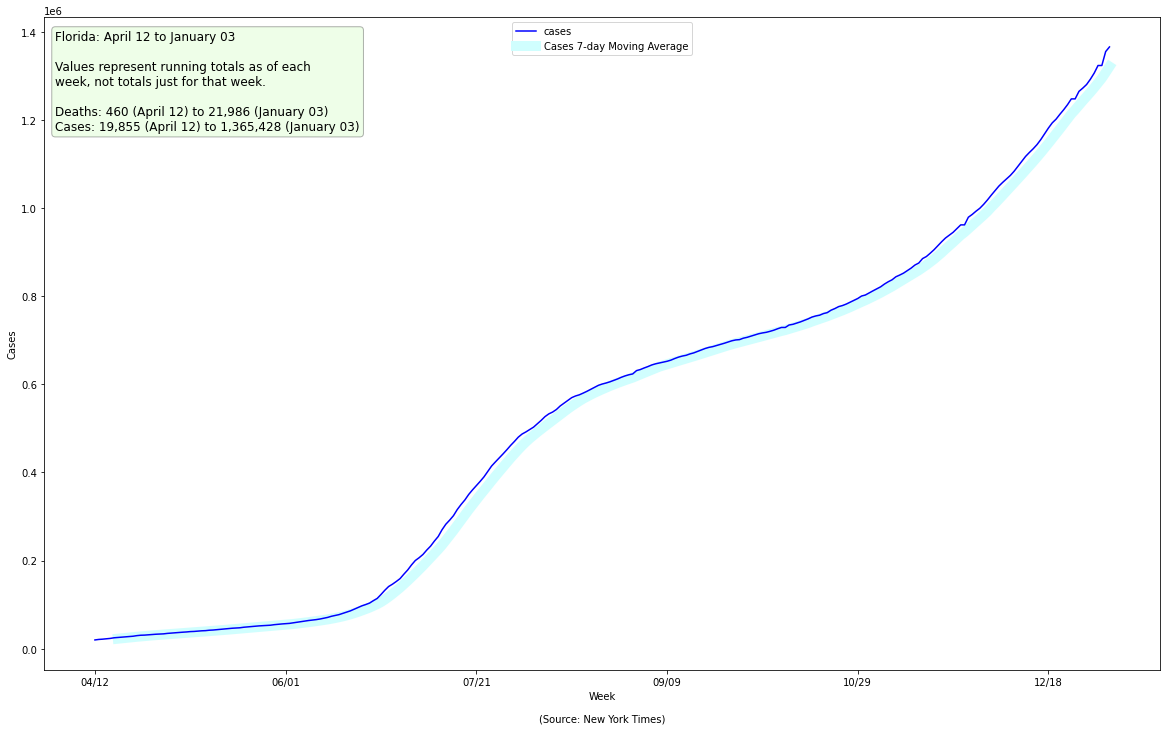

In [49]:
plot_state(df_states, SOURCE, 'Florida', moving_average=True,
           image_file='nyt-fl-cases.png', metrics={MetricType.CASES});

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [50]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

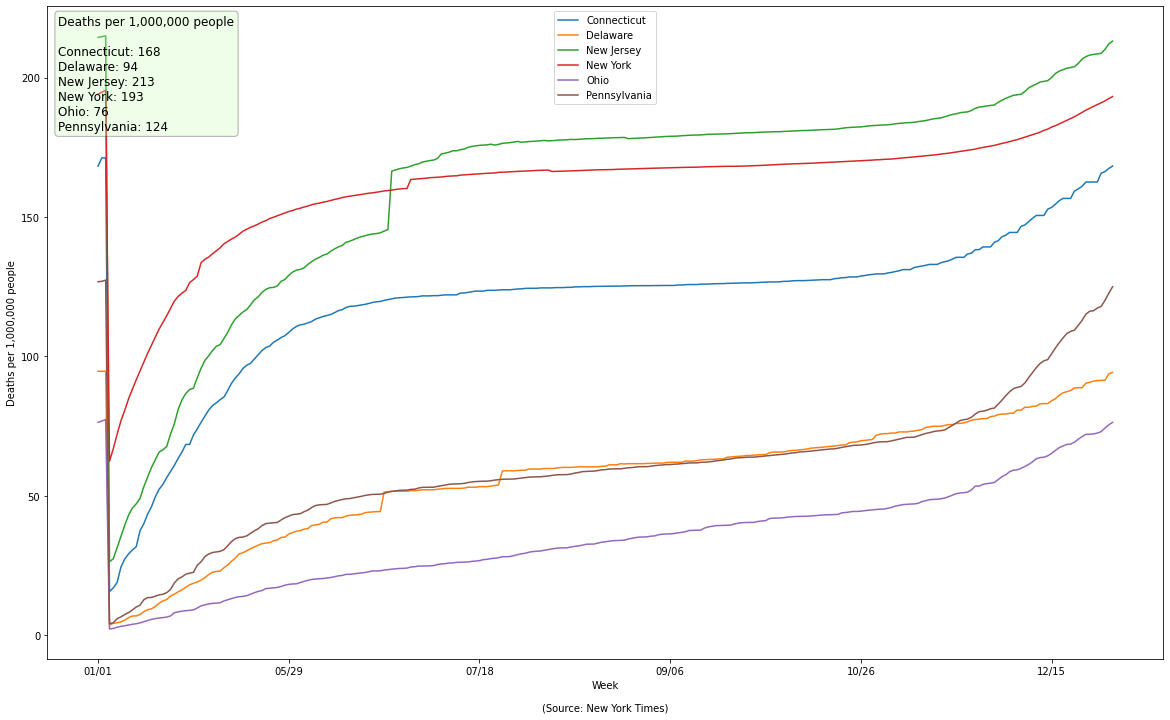

In [51]:
plot_states(df_states, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='upper center', image_file='nyt-ne-states-deaths-per-capita.png');

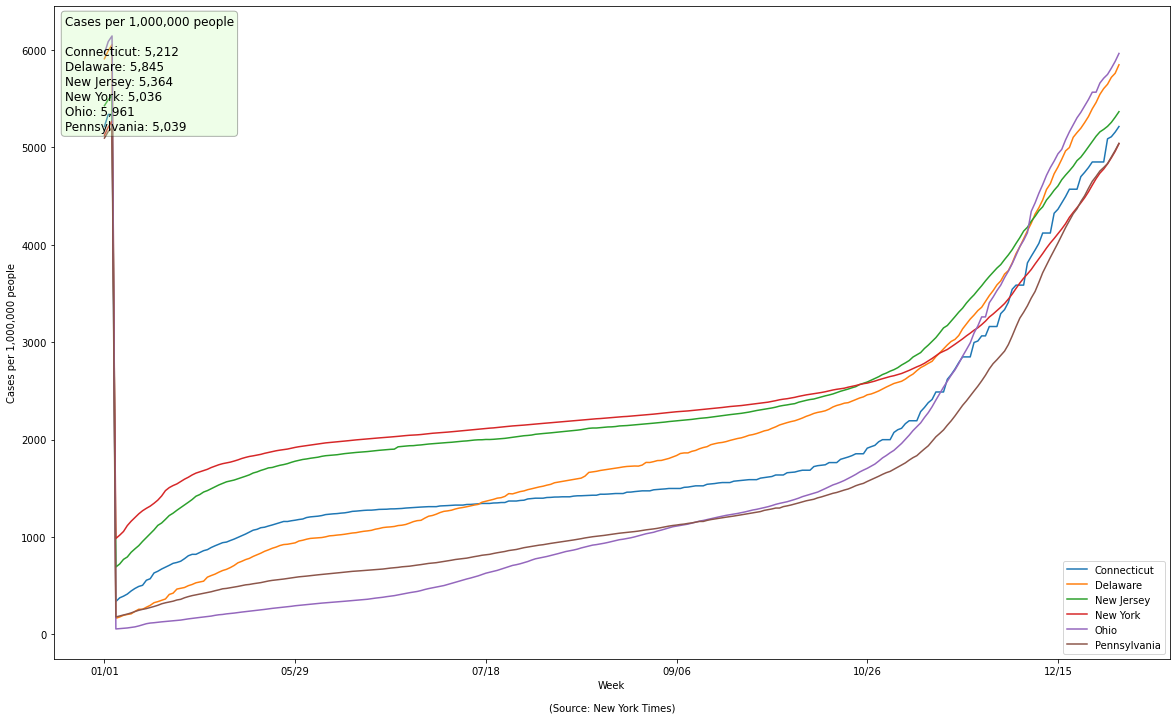

In [52]:
plot_states(df_states, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            legend_loc='lower right', image_file='nyt-ne-states-cases-per-capita.png');

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [53]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

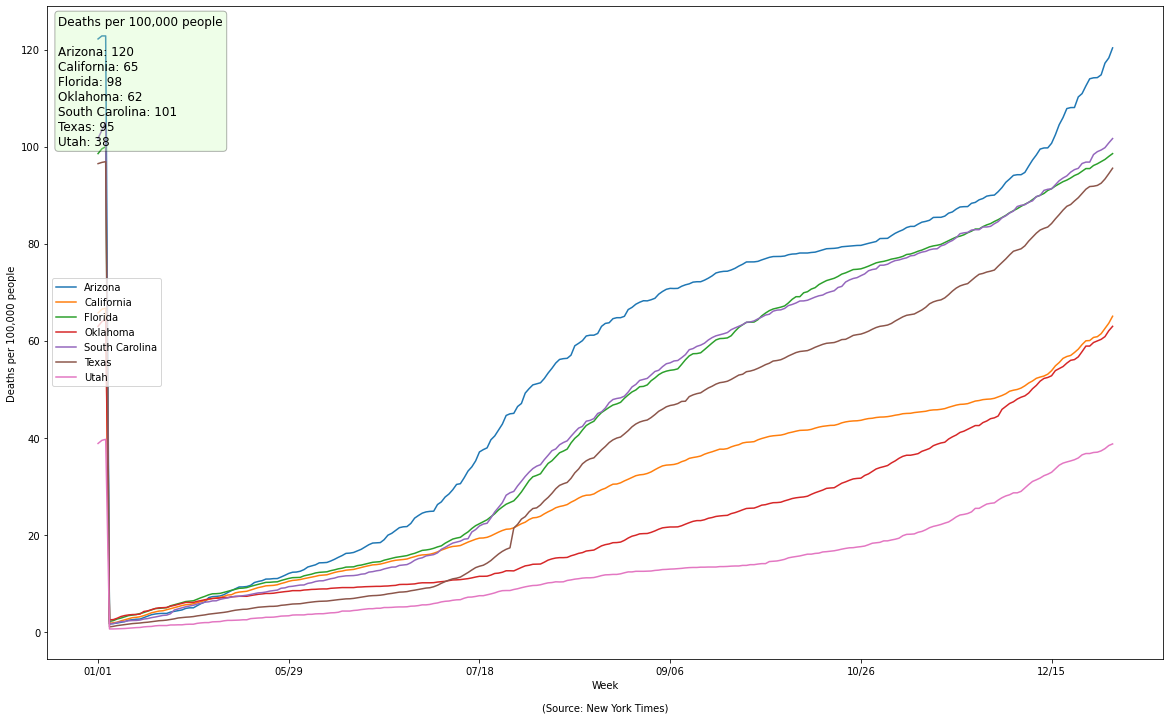

In [54]:
plot_states(df_states, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='nyt-s-sw-states-deaths-per-capita.png');

(<Figure size 1440x864 with 1 Axes>,
 <AxesSubplot:xlabel='Week\n\n(Source: New York Times)', ylabel='Cases per 100,000 people'>)

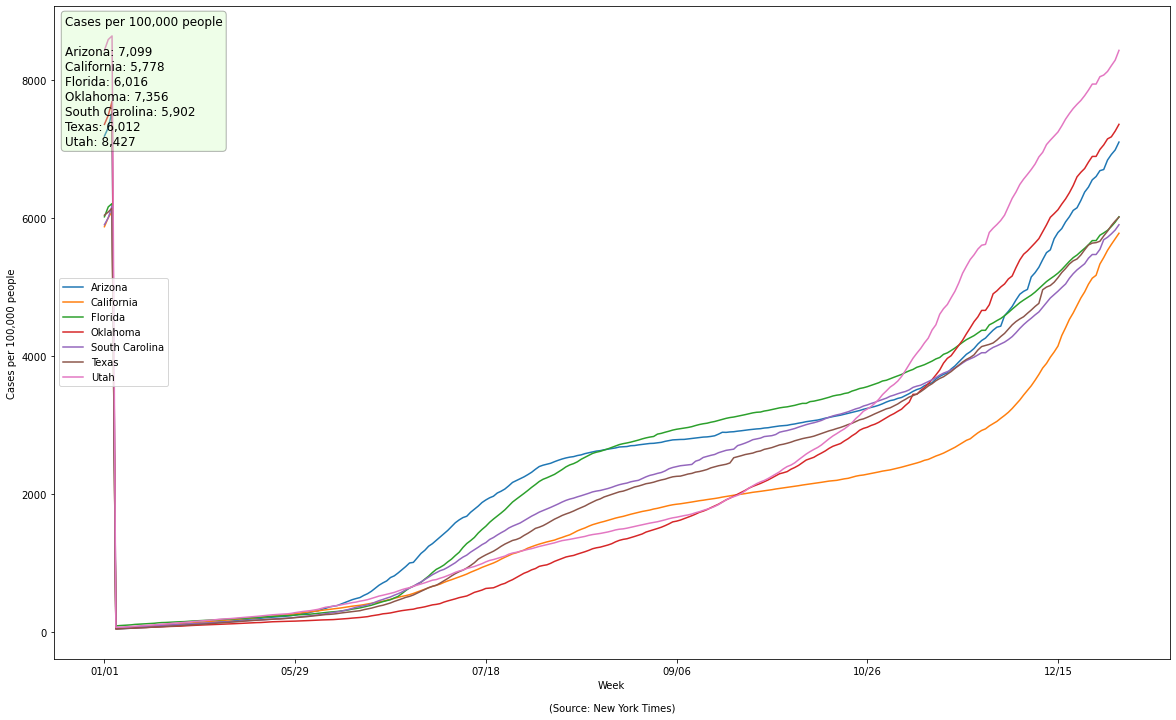

In [55]:
plot_states(df_states, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='nyt-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [56]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

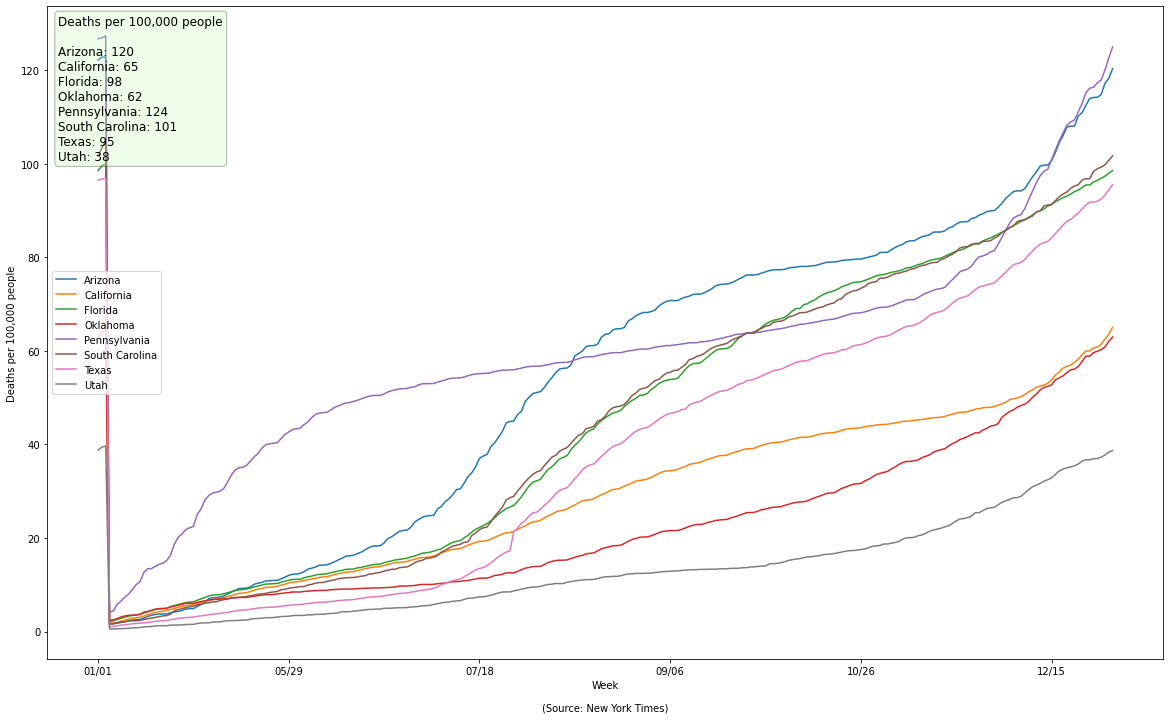

In [57]:
plot_states(df_states, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='nyt-s-sw-states-with-pa-deaths-per-capita.png');

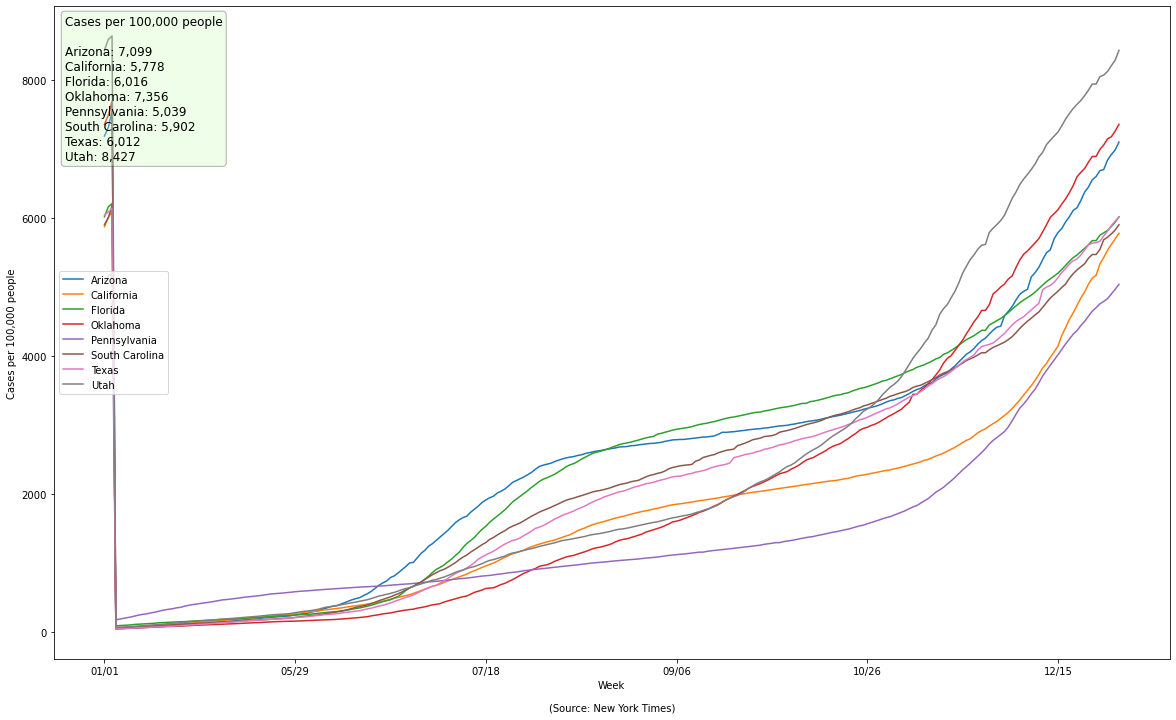

In [58]:
plot_states(df_states, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='nyt-s-sw-states-with-pa-cases-per-capita.png');

## Per-capita rates for all states

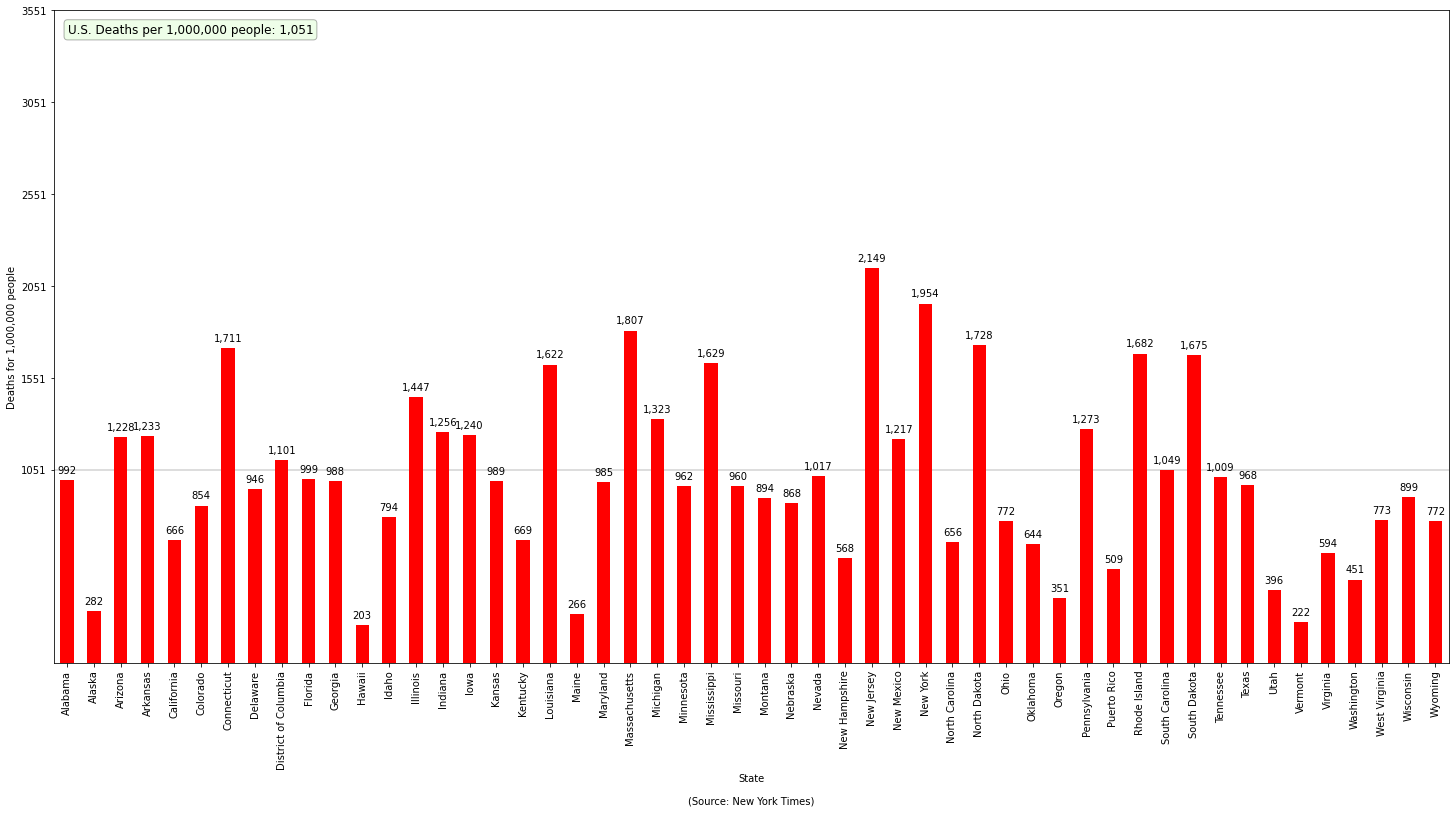

In [59]:
plot_states_per_capita(df_states, SOURCE, populations, image_file='nyt-state-deaths-per-capita.png');

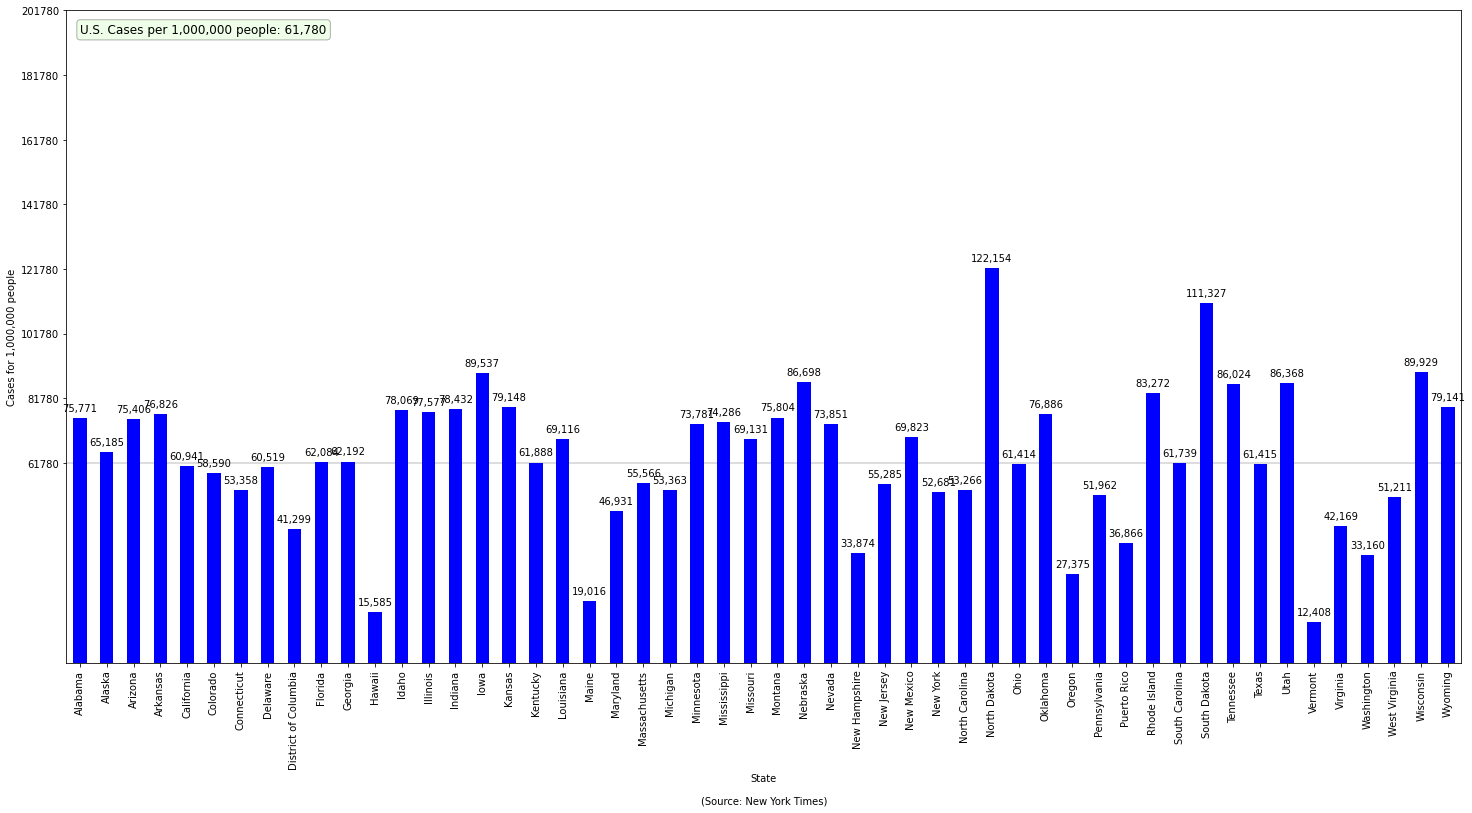

In [60]:
plot_states_per_capita(df_states, SOURCE, populations, metric=MetricType.CASES, image_file='nyt-state-cases-per-capita.png');

## Counties

### Some select Pennsylvania counties

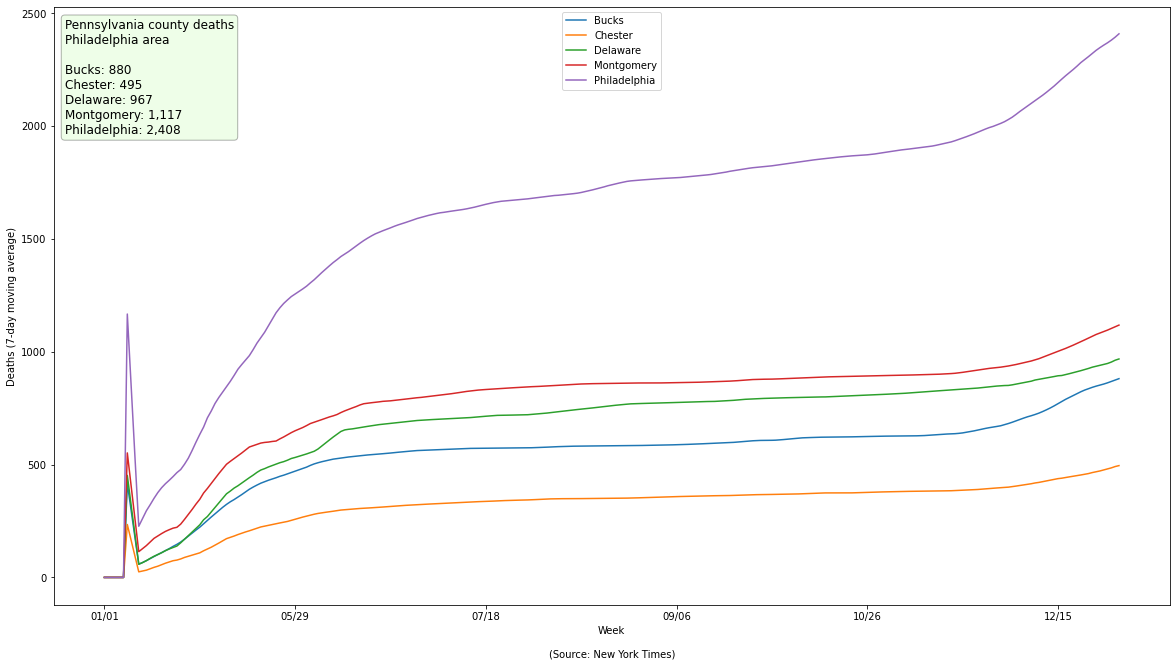

In [61]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.DEATHS, image_file='nyt-pa-phl-area-deaths.png')

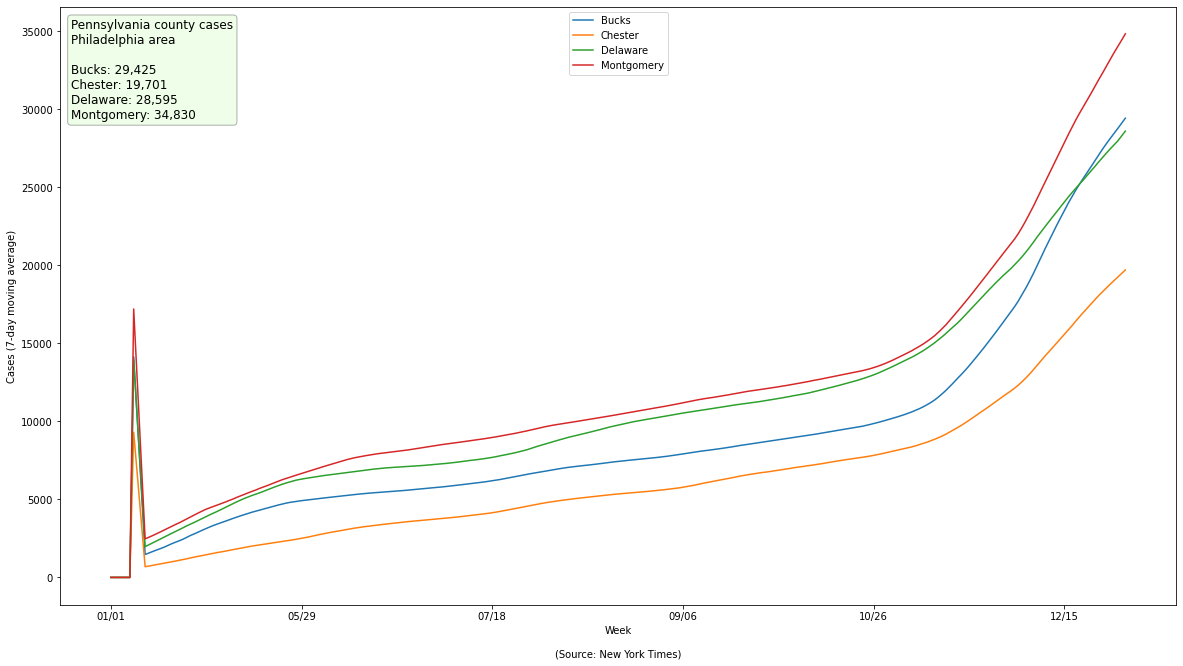

In [62]:
without_philly = set(philly_area_counties) - {'Philadelphia',}
plot_counties(df_counties, 'Pennsylvania', without_philly, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.CASES, image_file='nyt-pa-outside-phl-cases.png')

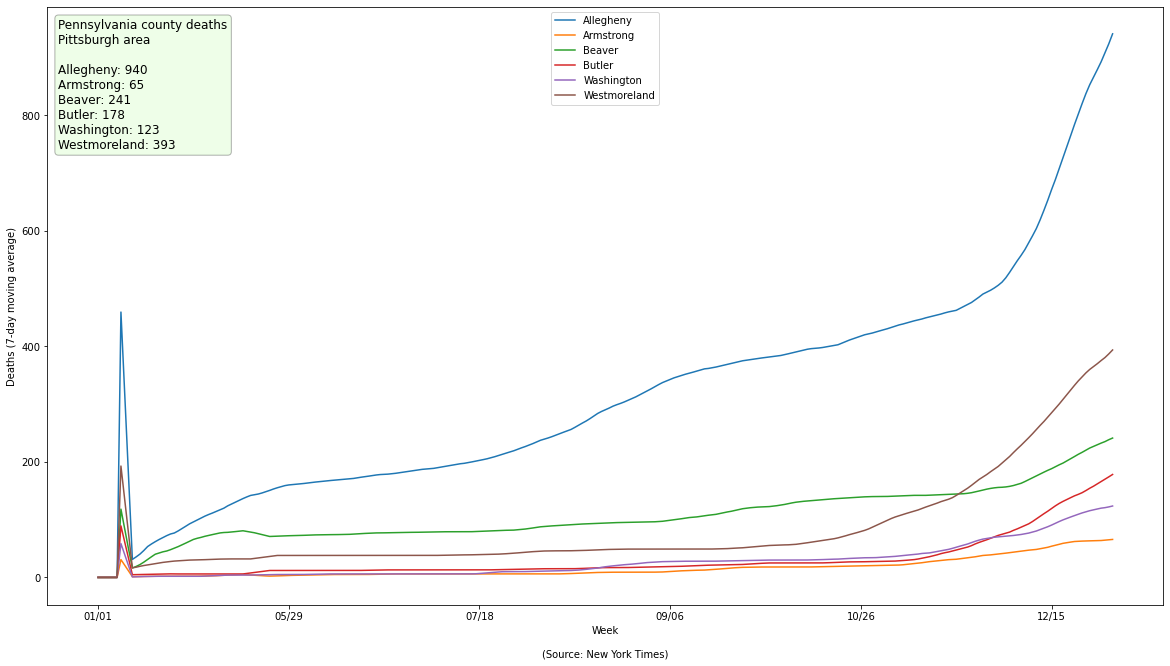

In [63]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.DEATHS, image_file='nyt-pgh-area-deaths.png')

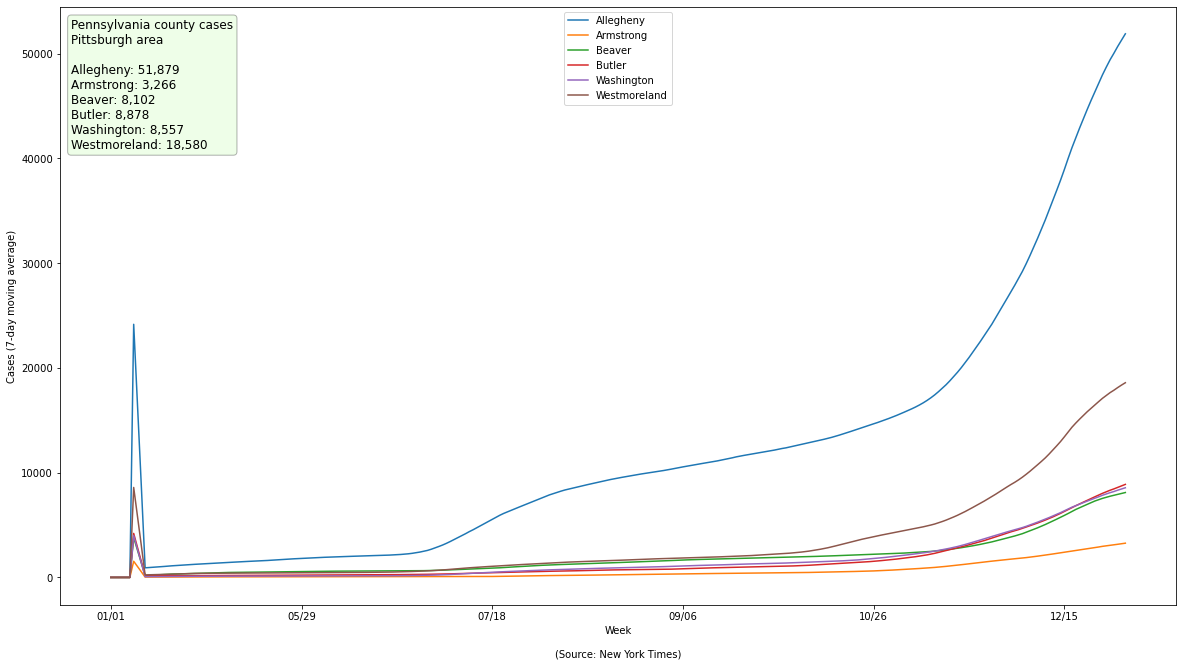

In [64]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.CASES, image_file='nyt-pgh-area-cases.png')

#### Some daily stats for certain counties

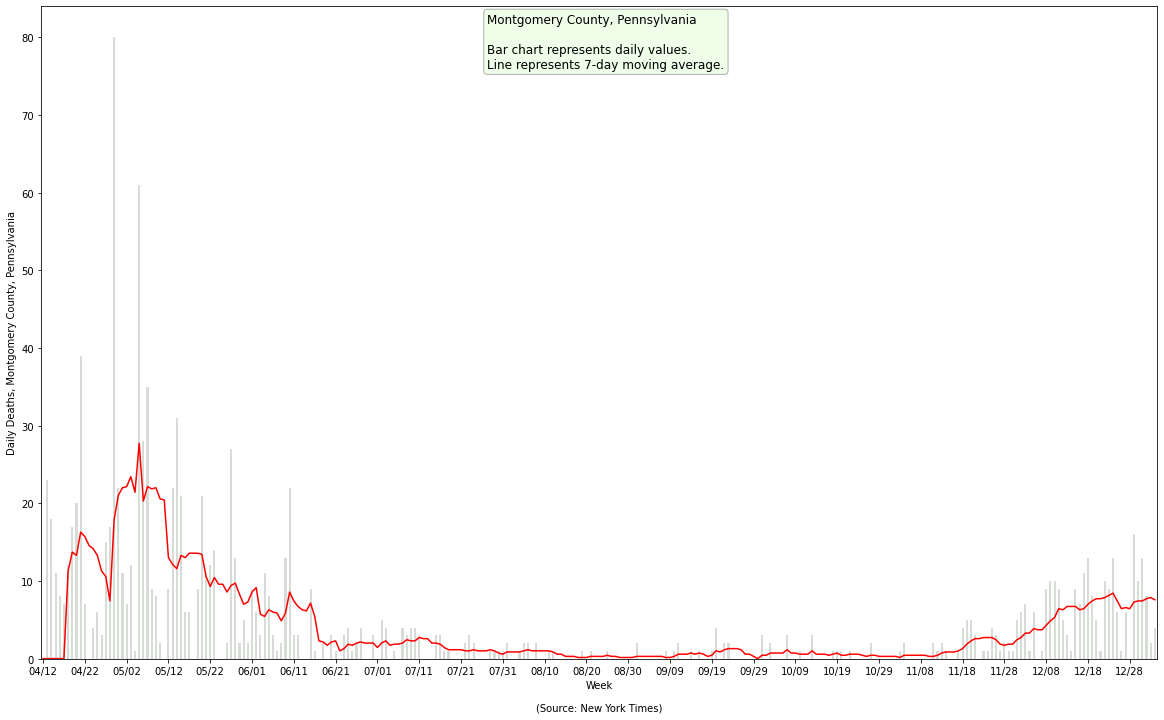

In [65]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.40, 0.99), image_file='nyt-pa-montgomery-county-daily-deaths.png');

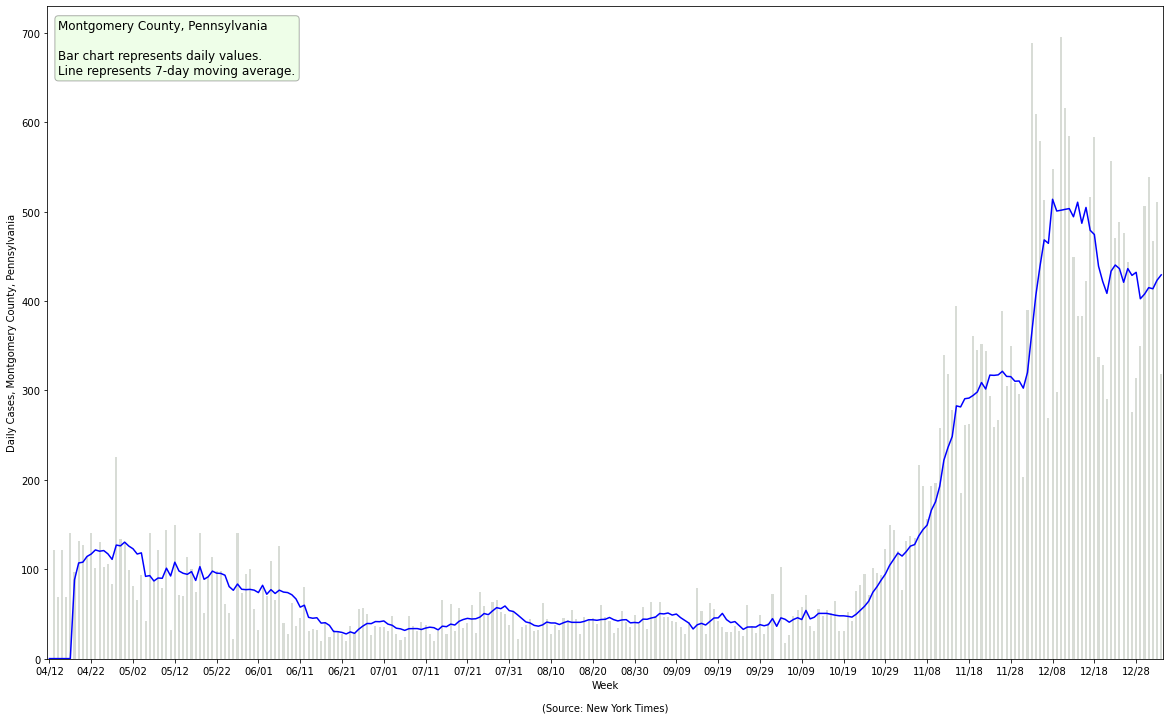

In [66]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-montgomery-county-daily-cases.png');

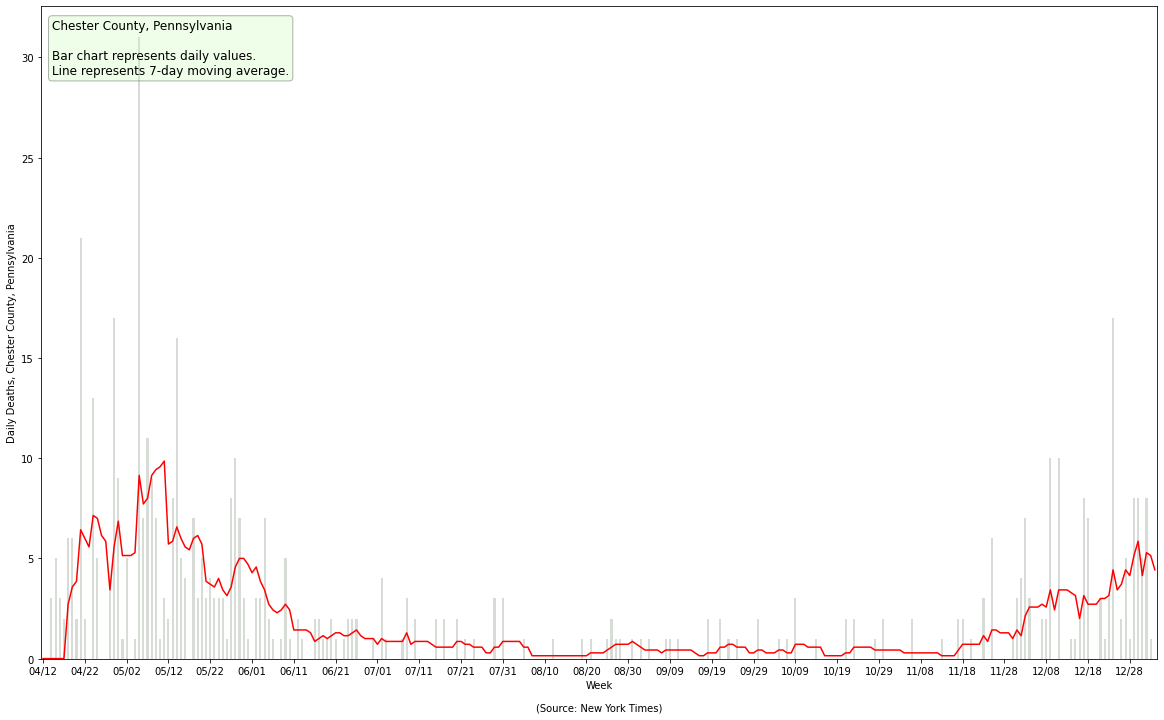

In [67]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-chester-county-daily-deaths.png');

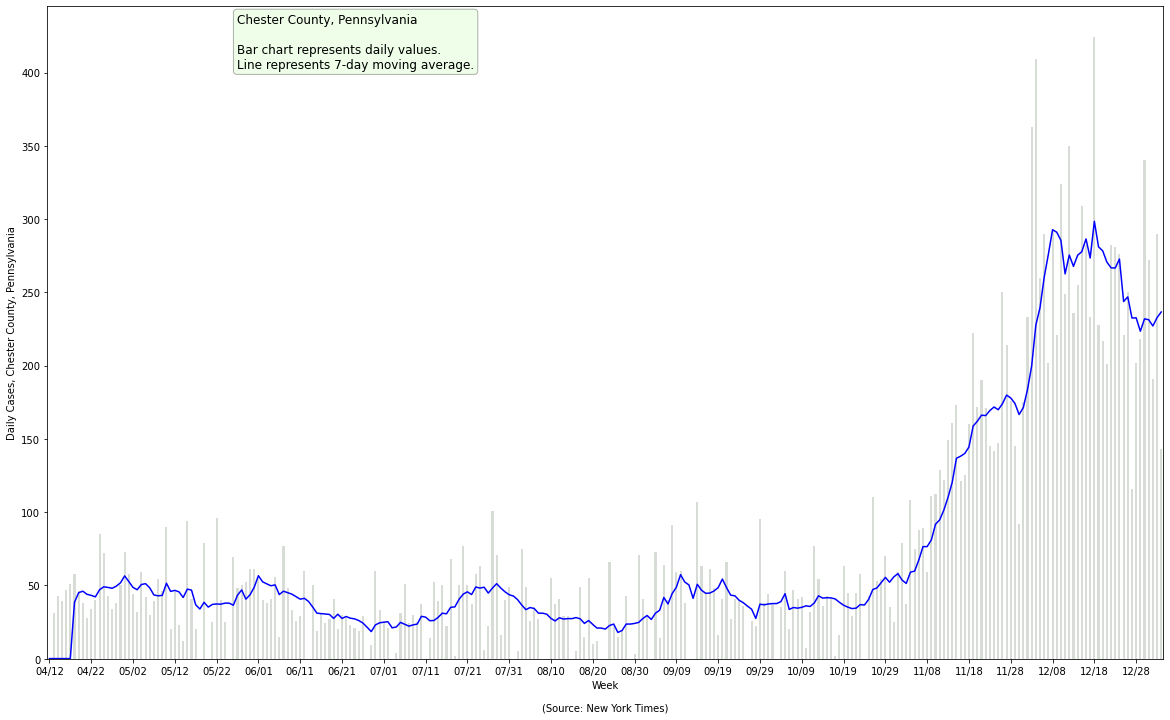

In [68]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.17, 0.99), image_file='nyt-pa-chester-county-daily-cases.png');

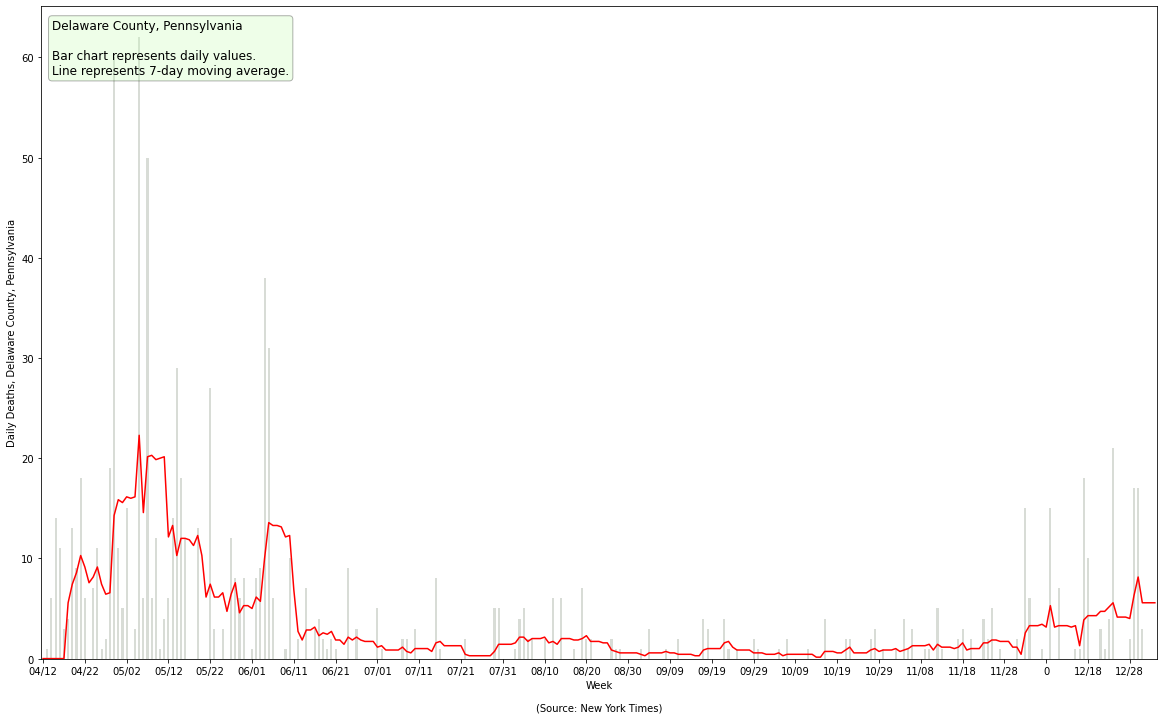

In [69]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-delaware-county-daily-deaths.png');

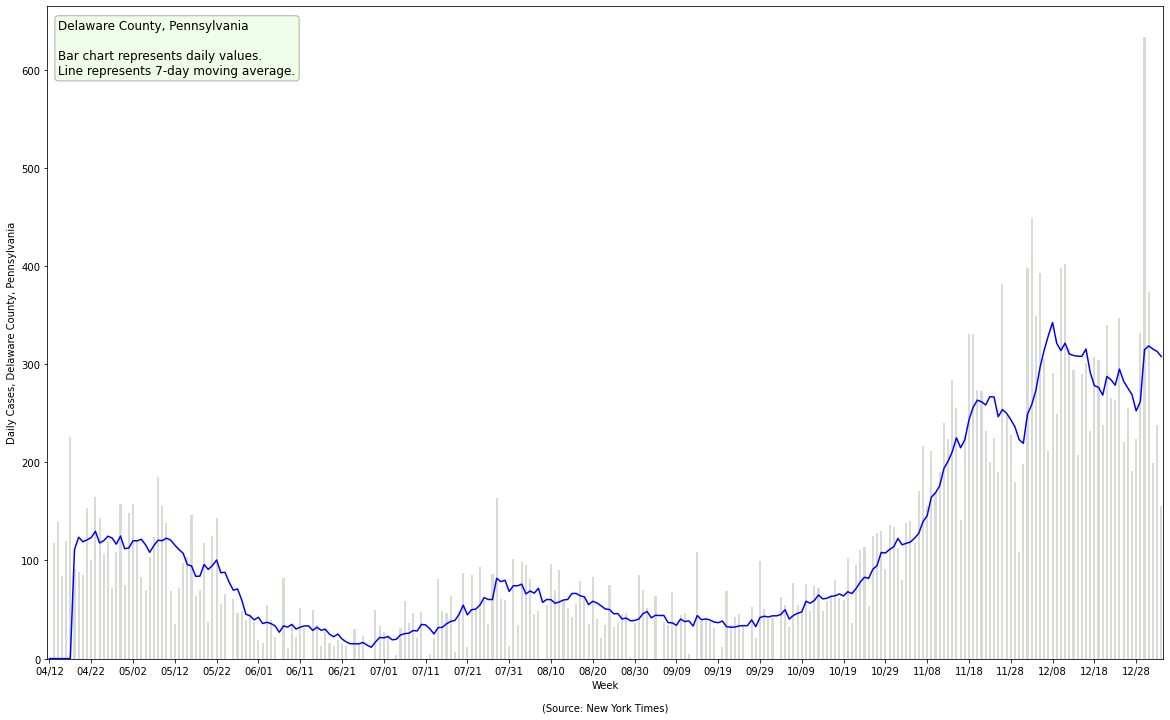

In [70]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-delaware-county-daily-cases.png');

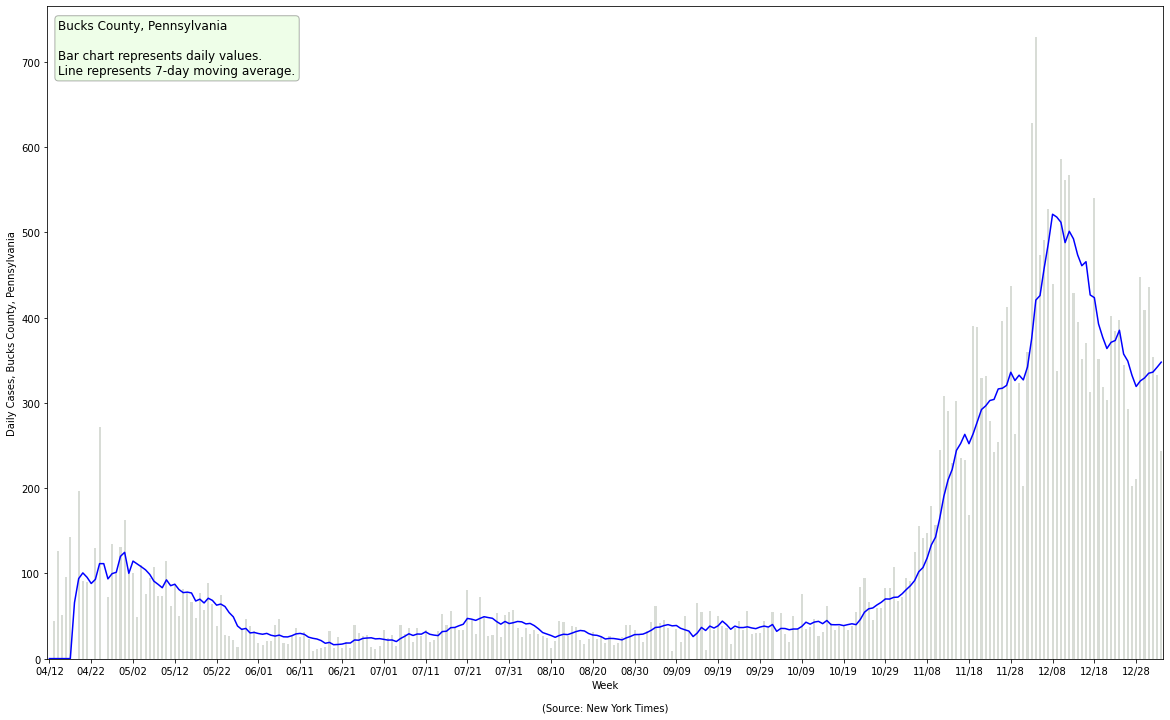

In [71]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-bucks-county-daily-cases.png');

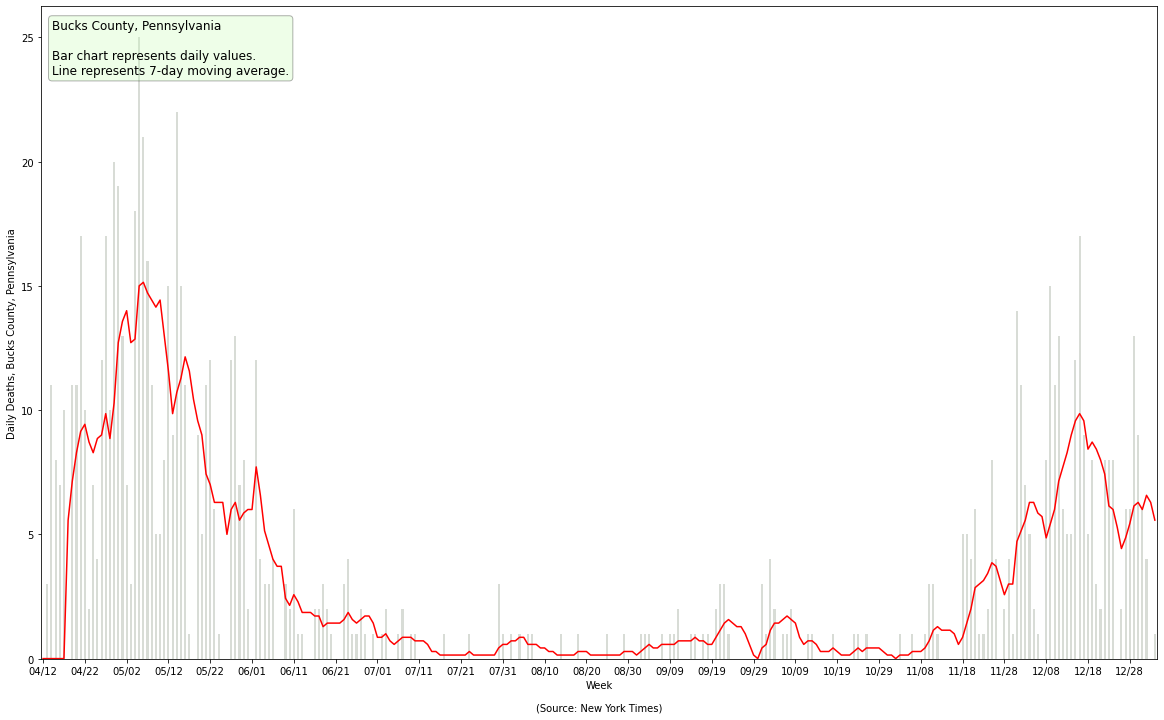

In [72]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-bucks-county-daily-deaths.png');

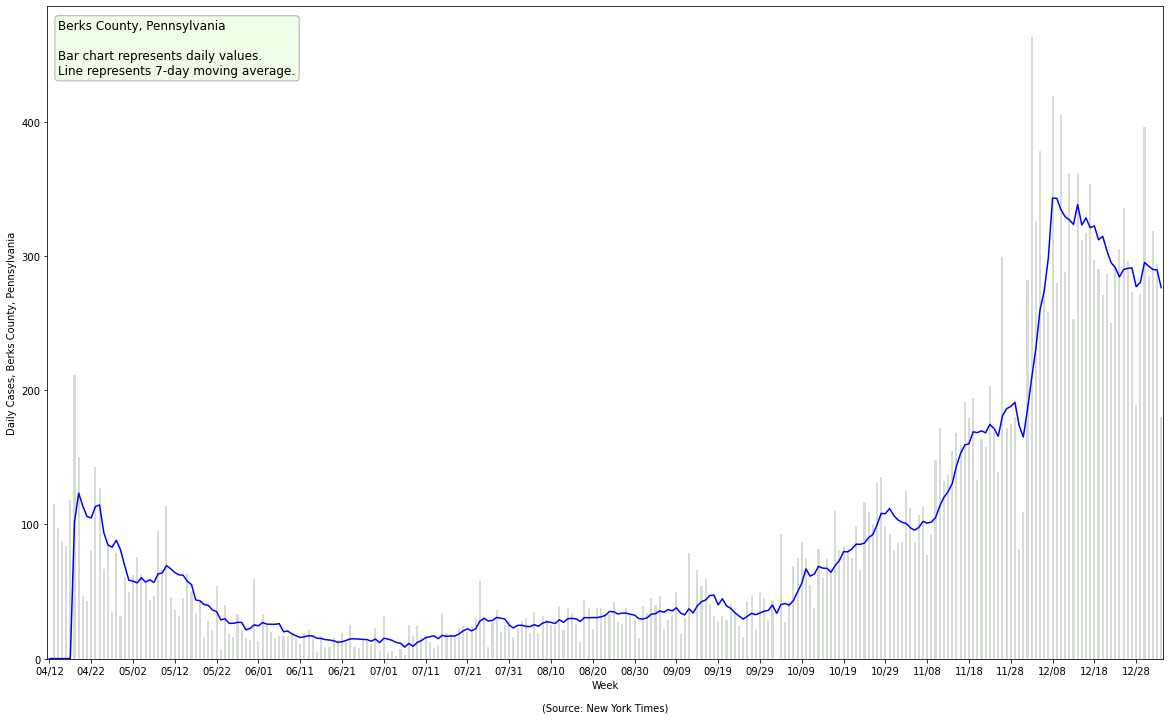

In [73]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-pa-berks-county-daily-cases.png');

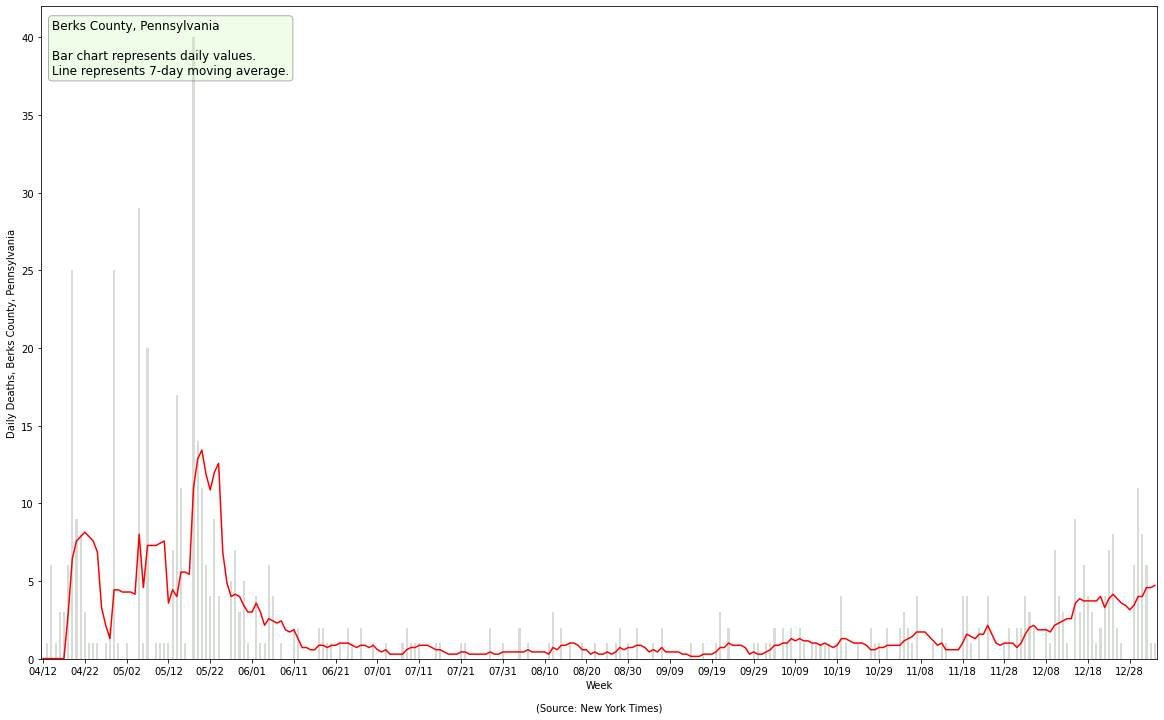

In [74]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-pa-berks-county-daily-deaths.png');

### Florida 

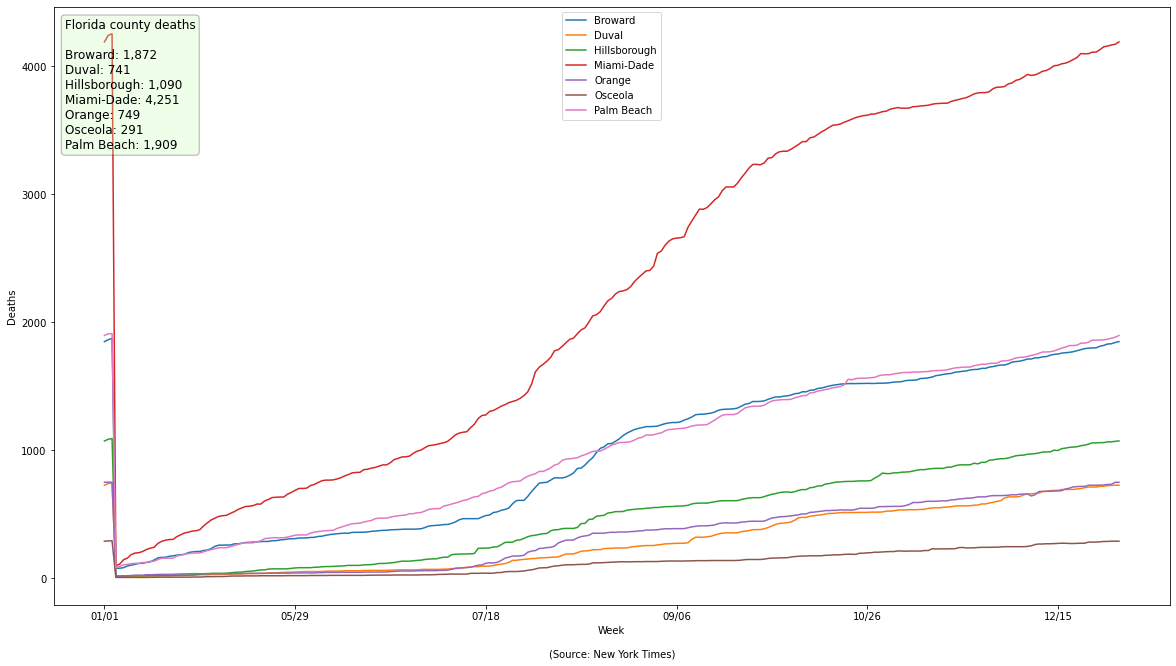

In [75]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-deaths.png', source=SOURCE, metric=MetricType.DEATHS)

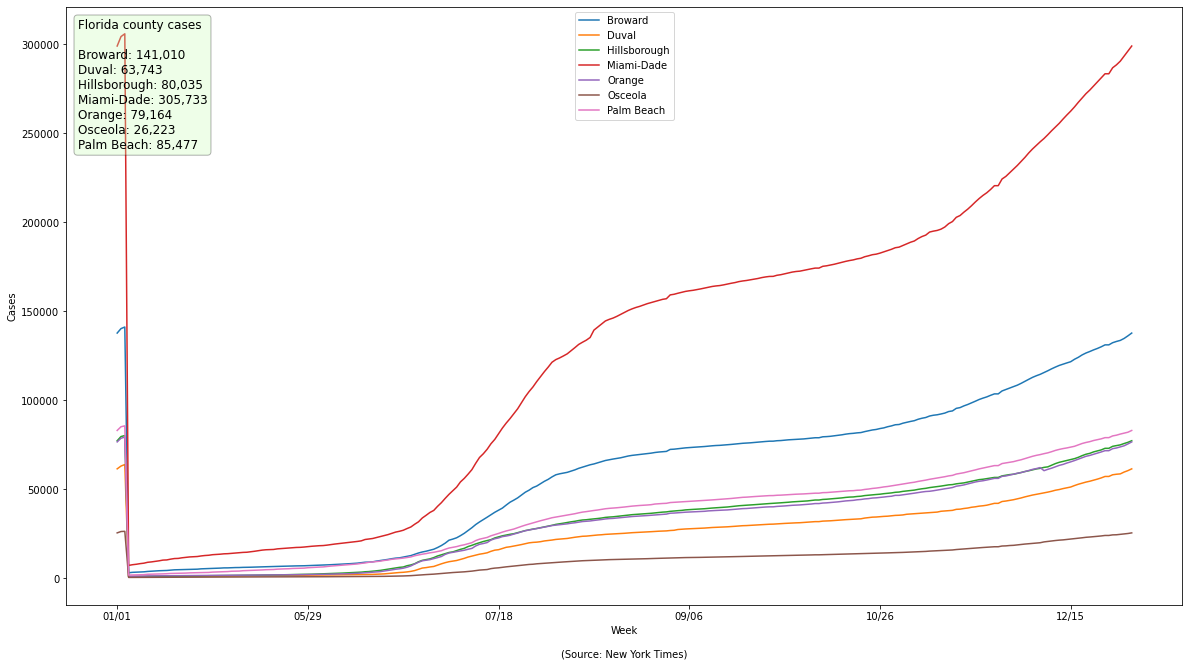

In [76]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', source=SOURCE, metric=MetricType.CASES)

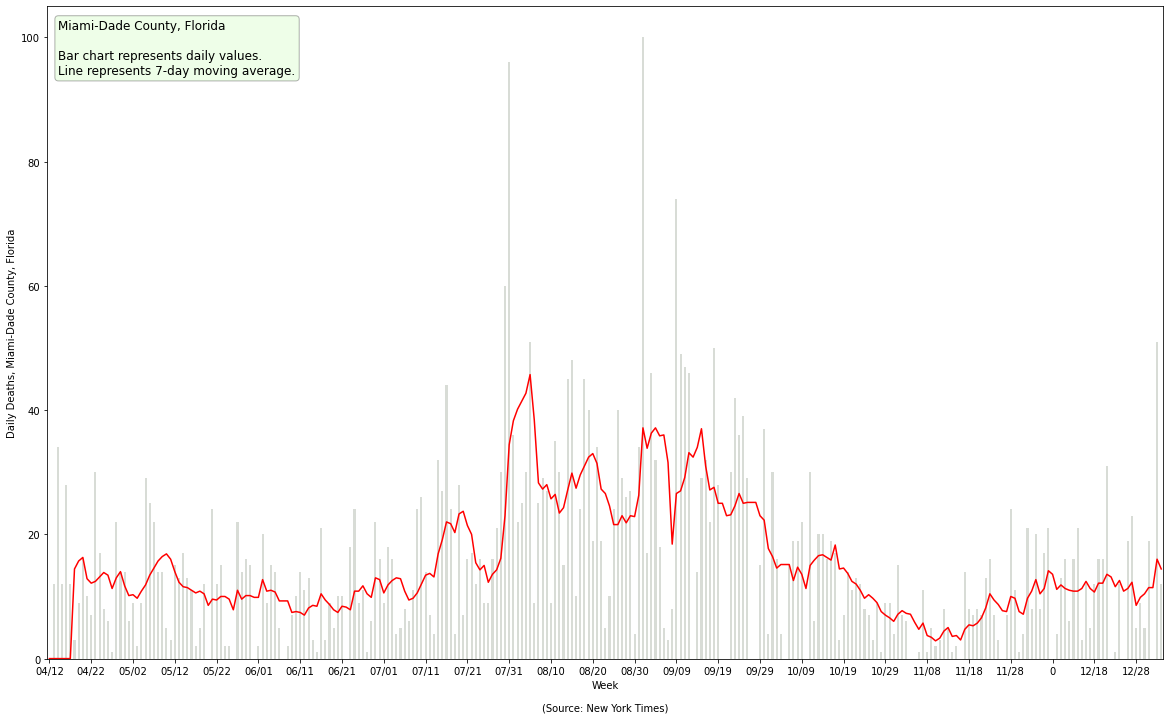

In [77]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='nyt-fl-miami-county-daily-deaths.png');

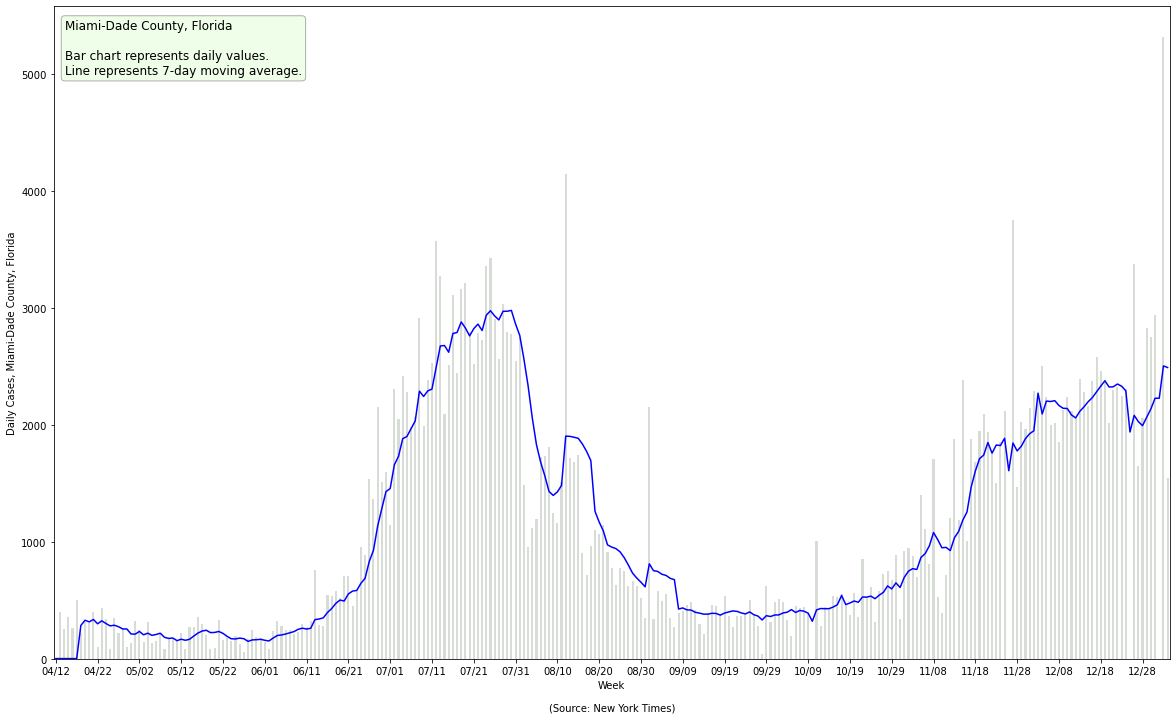

In [78]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='nyt-fl-miami-county-daily-cases.png');

### New York City

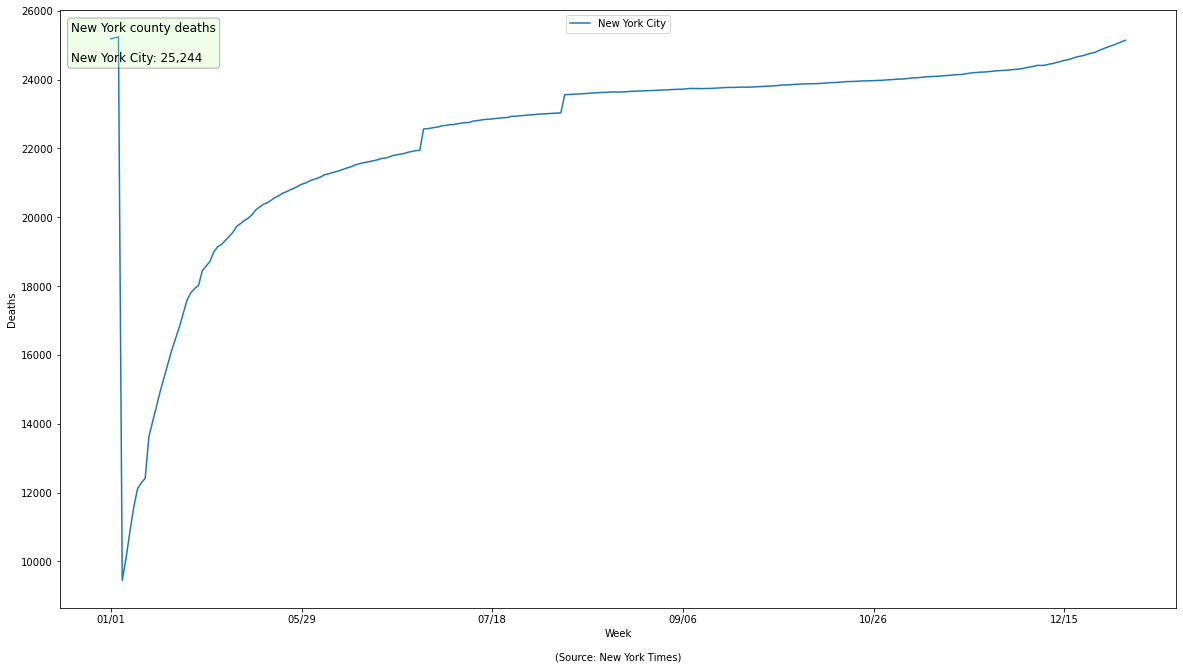

In [79]:
# The NY Times data coalesces the five New York City counties
# into "New York City".
plot_counties(df_counties, 'New York', ['New York City'], source=SOURCE, 
              image_file='nyt-nyc-county-deaths.png', metric=MetricType.DEATHS)

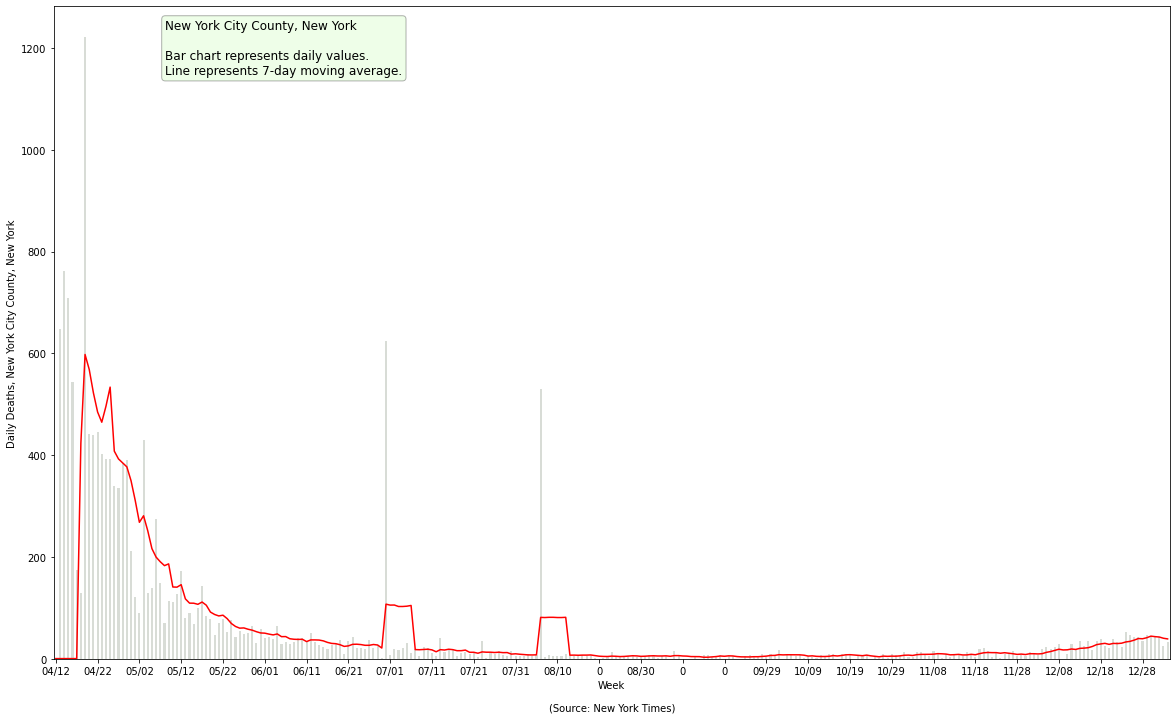

In [80]:
plot_county_daily_stats(df_counties, 'New York', 'New York City', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.10, 0.98), image_file='jhu-ny-nyc-daily-deaths.png');

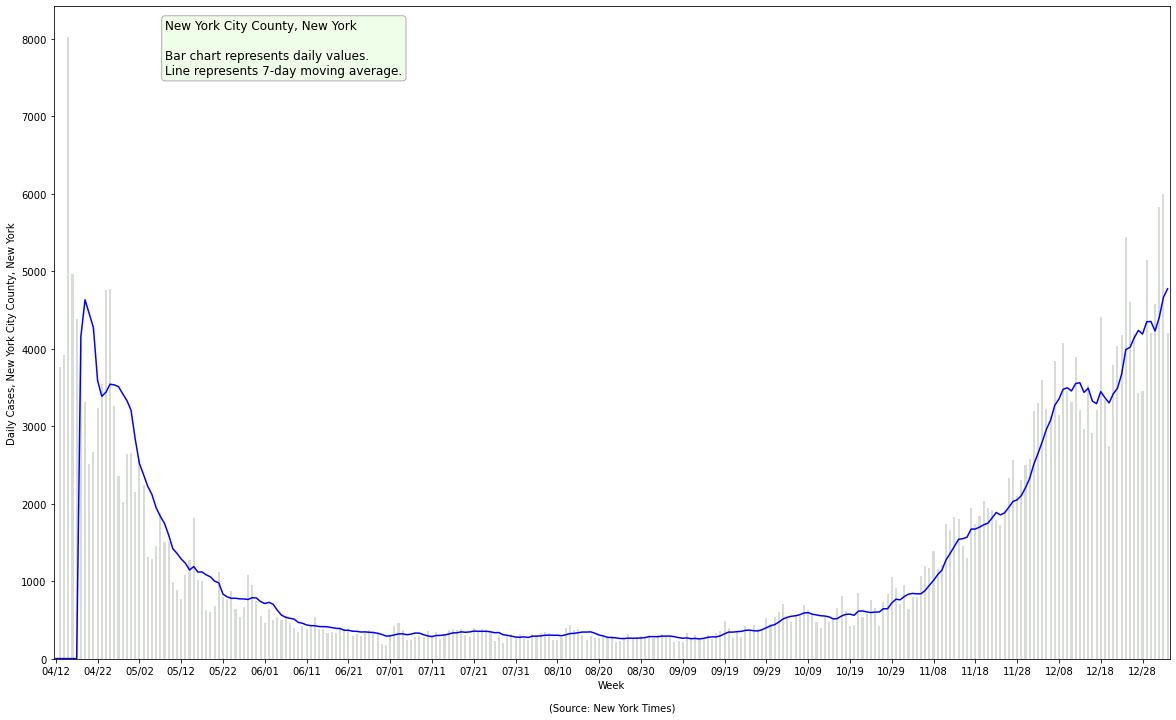

In [81]:
plot_county_daily_stats(df_counties, 'New York', 'New York City', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.10, 0.98), image_file='jhu-ny-nyc-daily-cases.png');